# DESI PV Y1 Group/Cluster TFR Calibration

Using the list of groups defined by Tully in [*Galaxy Groups: a 2MASS Catalog*](https://iopscience.iop.org/article/10.1088/0004-6256/149/5/171), AJ 149:171, 2015, identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-cluster joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **20 December 2024**

**Note:** This requires using a subclassed version of `hyperfit`.

Potential updates to this notebook:
* ~~Improved identification of spiral galaxy morphologies in the SGA (currently using LEDA morphological classification).~~
* Larger statistics of SN Ia calibrators with rotation curve measurements and independent distance moduli.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab10').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, search_around_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

# from desiutil.plots import init_sky

# Custom functions / classes
import sys
#insert you path below
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from help_functions import adjust_lightness
import hyperfit_v2 as hyperfit
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2
sig_choice = "sigV"

In [3]:
def hc_corr(z_inp, RA, Dec, direction="forward"):
    """
    A function to perform heliocentric correction using Planck (2018) CMB Dipole measurements.
    Inputs:
        z: input heliocentric or CMB frame redshift(s)
        RA: object equatorial right ascension(s)
        Dec: object equatorial declination(s)
        direction: string of the type of correction to be performed. Either 'forward' (default) or 'backward',
            respectively corresponding to the full correction and the same correction but backwards to go from 
            z_CMB to z_helio.

    Outputs:
        z_CMB (default, i.e. if direction is 'foward'): float or numpy array of heliocentric redshifts corrected
            to the CMB frame
        z_helio (only if direction is 'backward'): float or numpy array of CMB frame redshifts
            inverted to heliocentric frame
    """
    v_Sun_Planck = 369.82  # +/- 0.11 km/s
    l_dipole_Planck = 264.021  # +/- 0.011 deg
    b_dipole_Planck = 48.253  # +/- 0.005 deg
    c = 299792.458  # km/s
    
    if direction not in ["forward", "backward"]:
        print("Correction type unknown.")
        raise ValueError

    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u

    rad = np.pi / 180.0
    coord_helio_Planck = SkyCoord(
        l_dipole_Planck * u.degree, b_dipole_Planck * u.degree, frame="galactic"
    ).galactic
    coord = SkyCoord(RA * u.degree, Dec * u.degree, frame="icrs").galactic
    alpha = coord_helio_Planck.separation(coord).radian

    v_Sun_proj = v_Sun_Planck * np.cos(alpha)
    
    # Full special rel. correction since it is a peculiar vel
    z_Sun = np.sqrt((1.0 + (-v_Sun_proj) / c) / (1.0 - (-v_Sun_proj) / c)) - 1.0
    min_z = 0.0
    
    if direction == "forward":
        z_CMB = np.where(z_inp > min_z, (1 + z_inp) / (1 + z_Sun) - 1, z_inp)
    elif direction == "backward":
        # backwards correction where z_CMB is actually z_helio and vice versa
        z_helio = np.where(z_inp > min_z, (1 + z_inp) * (1 + z_Sun) - 1, z_inp)

    if direction == "backward":
        return z_helio
    else:
        return z_CMB


# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [4]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgatab = Table.read(sgafits)
# Using Tully/Kourkchi groups, no point searching above z=0.07, for tiny speedup
sgatab = sgatab[(sgatab["Z_DESI"] <= 0.07) & (sgatab["Z_DESI"] > 0)]
sgatab[:5]

<Table length=5>
SGA_ID   SGA_GALAXY           GALAXY         ...    V_0p4R26_err    PHOTSYS
int64     bytes16            bytes29         ...      float64        bytes1
------ ------------- ----------------------- ... ------------------ -------
    55   SGA-2020 55              PGC1203947 ... 3.1180004761210594       S
   223  SGA-2020 223 SDSSJ131108.84+341016.9 ...   4.27530627605531       N
   581  SGA-2020 581              PGC1576398 ... 4.4513439166676285       S
  1158 SGA-2020 1158              PGC1245110 ... 1.7670419483960598       S
  1287 SGA-2020 1287              PGC1076731 ... 10.745769600707723       S

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [5]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

<Table length=9710>
  SGA_ID  Spiral_Pred Elliptical_Pred Lenticular_Pred Irregular_Pred
 float64      str6         str10           str10           str9     
--------- ----------- --------------- --------------- --------------
   2371.0       Other           Other           Other      Irregular
   2406.0      Spiral           Other           Other          Other
   4614.0      Spiral           Other           Other          Other
   7707.0      Spiral           Other           Other          Other
   8119.0      Spiral           Other           Other          Other
   8832.0      Spiral           Other           Other          Other
   9415.0       Other           Other           Other      Irregular
  11933.0      Spiral           Other           Other          Other
  12347.0       Other           Other           Other      Irregular
      ...         ...             ...             ...            ...
5002400.0      Spiral           Other           Other          Other
5002410.0      Spiral           Other           Other          Other
5002425.0      Spiral           Other           Other          Other
5002603.0      Spiral           Other           Other          Other
5002677.0      Spiral           Other           Other          Other
5002752.0      Spiral           Other           Other          Other
5002778.0       Other           Other           Other      Irregular
5002994.0      Spiral           Other           Other          Other
5003044.0      Spiral           Other           Other          Other
5003075.0      Spiral           Other           Other          Other

In [6]:
sum(ai_morphtab['Spiral_Pred'] == 'Spiral') + sum(ai_morphtab['Elliptical_Pred'] == 'Elliptical') + sum(ai_morphtab['Lenticular_Pred'] == 'Lenticular') + sum(ai_morphtab['Irregular_Pred'] == 'Irregular')

np.int64(9710)

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [7]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

# Combine ML morphtypes with SGA catalog

In [8]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
'''

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [9]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max
'''
#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
'''
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

[Text(0, 0.5, 'count')]

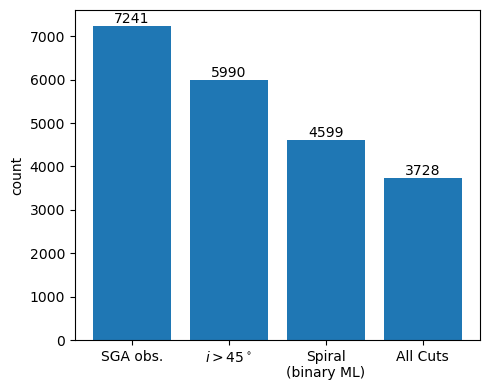

In [10]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count') #, yscale='log', ylim=[1e3,1.2e4])

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none')

# Photometric corrections

### Survey offsets

In [11]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [12]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [13]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/u1/k/kadglass/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [14]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [15]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [16]:
# kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
#                    [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
#                    [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
#                    z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)
with open("../kcorr_cal_ipynb.pkl", "rb") as inp:
    kcorr_zg0 = pickle.load(inp)

In [17]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [18]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [20]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [21]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [22]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [23]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [24]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')
zeroptab["MU_ERR"]/=np.sqrt(2)  # MU_ERR column is approximately sqrt(2) too large currently

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab

<Table length=23>
  SGA_ID     SGA_GALAXY    ...        MU_ERR        MU_SOURCE 
 float64      bytes16      ...       float64         bytes22  
--------- ---------------- ... ------------------- -----------
  40926.0   SGA-2020 40926 ... 0.12557509327091895   SN2017cjv
 109750.0  SGA-2020 109750 ... 0.12270565395286395      2005hc
 122260.0  SGA-2020 122260 ...  0.1544886895536369      2010ai
 124900.0  SGA-2020 124900 ...  0.1057782247180392     PS16ayd
 185629.0  SGA-2020 185629 ...  0.2408448123128252      2007ba
 236390.0  SGA-2020 236390 ... 0.10919779311185734     PS16bnz
 364828.0  SGA-2020 364828 ... 0.22690066658782648      2006bw
 431725.0  SGA-2020 431725 ... 0.23414002581361432      2001ep
 506101.0  SGA-2020 506101 ... 0.10919779311185734     PS16bnz
      ...              ... ...                 ...         ...
 927499.0  SGA-2020 927499 ...  0.2408448123128252      2007ba
 995924.0  SGA-2020 995924 ...  0.1544886895536369      2010ai
 999275.0  SGA-2020 999275 ... 0.14641070168536177 ASASSN-16ct
1031134.0 SGA-2020 1031134 ... 0.13449029556811895   AT2017cfc
1128555.0 SGA-2020 1128555 ... 0.22519300371126097       2002G
1146354.0 SGA-2020 1146354 ... 0.23004234201663828      2001da
1290887.0 SGA-2020 1290887 ... 0.11938437340163076     PS16axi
1356418.0 SGA-2020 1356418 ...  0.1057782247180392     PS16ayd
1371372.0 SGA-2020 1371372 ...  0.2582516599452944      1999ac
1385169.0 SGA-2020 1385169 ... 0.14376329389659934     PS15cms

Text(0.5, 0, 'z')

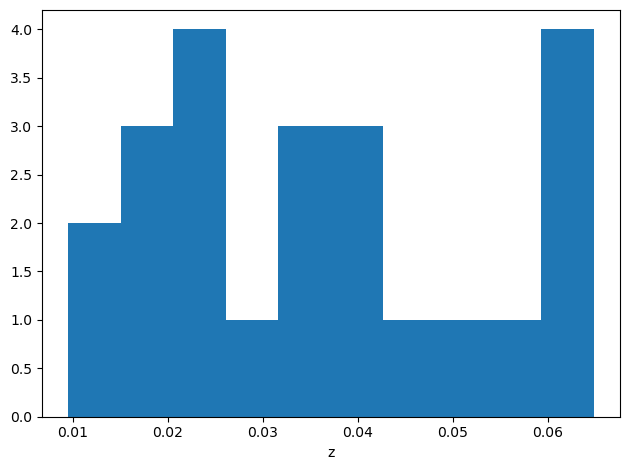

In [25]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z')

In [26]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [27]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=15>
      1999ac
      2001da
      2001ep
       2002G
      2005hc
      2006bw
      2007ba
      2010ai
 ASASSN-16ct
   AT2017cfc
     PS15cms
     PS16axi
     PS16ayd
     PS16bnz
   SN2017cjv,
 array([1, 1, 1, 1, 1, 1, 2, 2, 1, 4, 1, 2, 2, 2, 1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

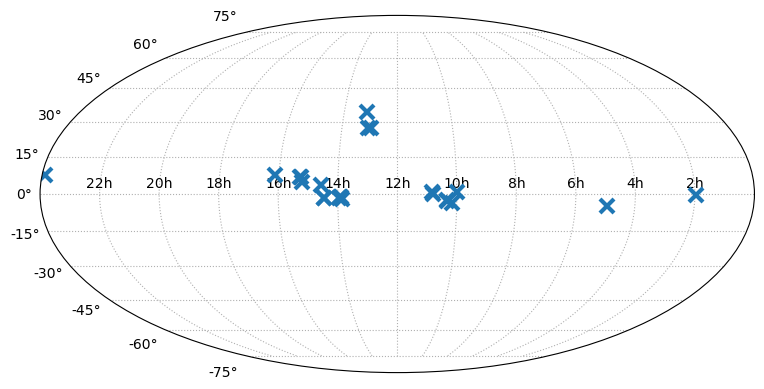

In [28]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':')

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150)

In [29]:
# ax = init_sky()

# ax.scatter(ax.projection_ra(sne_coords.ra.value), 
#            ax.projection_dec(sne_coords.dec.value), 
#            marker='x', 
#            s=100,
#            linewidth=3,
#            color='tab:blue')

# ax.xaxis.label.set_size(14)
# ax.yaxis.label.set_size(14)

# plt.tick_params(axis='both', which='major', labelsize=12)

# # plt.savefig('../../Figures/Y1/iron_0pt_sky.png', dpi=150, facecolor='none')

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [30]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [31]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These clusters come from the group catalog used by Kourkchi et al. in [*CosmicFlows-4: The Calibration of Optical and Infrared Tully-Fisher Relations*](https://iopscience.iop.org/article/10.3847/1538-4357/ab901c), ApJ 896:3, 2020.

Cluster membership is defined as
1. $R_p < 1.5R_{2t}$ AND $v < V_c \pm 3\sigma_p$, OR
1. $1.5R_{2t} \leq R_p < 3R_{2t}$ AND $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [32]:
################## old ###################
# clusters = Table.read('../Tully15-Table3.fits')
# clusters[:5]

################# new ####################
# takes a bit of work to use the two catalogues together
clusters = Table.read("../Tully15-Table3.fits")
clusters = clusters.to_pandas()

cz_cmb = clusters["<Vcmba>"].values
cls_coords = SkyCoord(
    clusters["SGLON"], clusters["SGLAT"], unit="deg", frame="supergalactic"
).icrs
z_hel = hc_corr(cz_cmb/c_kms, cls_coords.ra.deg, cls_coords.dec.deg, "backward")
clusters["HRV"] = z_hel*c_kms

print(clusters.columns, len(clusters))#,clusters)

clusters_new = Table.read("../Kourkchi17.fits")
clusters_new = clusters_new.to_pandas()
print(clusters_new.columns, len(clusters_new))

clusters_new["Nmb"] = clusters_new["Nm"]
clusters_new["DM"] = 5.0*np.log10(clusters_new["Dist"]) +25
clusters_new["Nest"] = np.char.add("3",clusters_new["PGC1"].values.astype("str")).astype("int")
clusters_new["sigP"] = clusters_new["sigmaL"]
clusters_new["sigV"] = clusters_new["sigmaV"]

# Should be safe to merge on PGC1 since Kourkchi is just updated Tully
clusters_new = clusters_new.set_index("PGC1")
clusters = clusters.set_index("PGC1")
used_cols = ["Nest","Nmb","PGC1", "SGLON", "SGLAT","DM", "sigV","sigP","R2t","HRV"]
clusters_join = pd.concat([clusters,clusters_new]).groupby(level=0).last().reset_index()
clusters = clusters_join[clusters_join["Nmb"]>=5][used_cols]
# clusters = clusters_join[used_cols]

# print(clusters_join.sort_values(by="Nmb")[used_cols][-10:])
print(clusters.sort_values(by="Nmb"))


Index(['f_Nest', 'Nest', 'Nmb', 'PGC1', 'SGLON', 'SGLAT', 'logLK', '<Vcmba>',
       'DM', 'sigV', 'R2t', 'sigP', 'Mlum', 'CF', 'HRV'],
      dtype='object') 25474
Index(['PGC1', 'PGC1_', 'Nm', 'GLON', 'GLAT', 'SGLON', 'SGLAT', 'Ksmag',
       'logK', 'HRV', 'VLS', 'Nd', 'Dist', 'e_Dist', 'sigmaL', 'sigmaV', 'R2t',
       'Rg', 'logMK', 'logMd', 'CF3', '_RA_icrs', '_DE_icrs'],
      dtype='object') 8826
         Nest  Nmb     PGC1     SGLON    SGLAT         DM  sigV  sigP    R2t  \
9898   100437    5    36450  102.6171 -14.5085  34.160000   229   305  0.622   
4828   200525    5    18945  224.1706 -69.3024  34.880000   108   359  0.731   
4794   100486    5    18841   15.3455 -45.5256  34.040000   125   272  0.553   
4788   100460    5    18811   15.3239 -44.8245  34.870000   173   384  0.781   
28818  200485    5  3088095  348.7357 -18.7209  34.000000   183   214  0.435   
...       ...  ...      ...       ...      ...        ...   ...   ...    ...   
14834  200002  167    57612  188.

# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Tully (2015).

Loop through the data and keep only clusters where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [33]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA'], sgatab_sel['DEC'], unit='deg')
# z_sga_desi = sgatab_sel['Z_DESI']
z_sga = sgatab_sel['Z_DESI']

100%|██████████| 1321/1321 [00:00<00:00, 2900.75it/s]


(10, 2600)

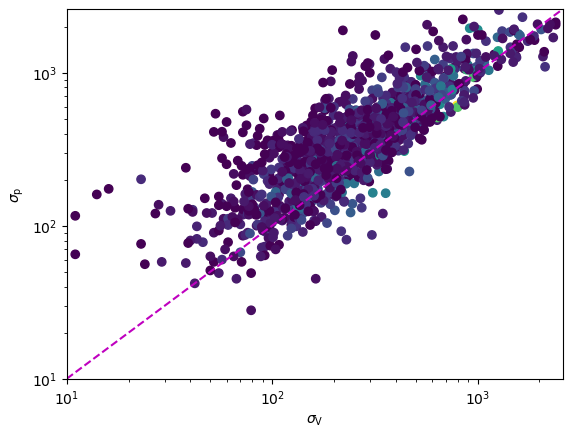

In [34]:
# sga_clusters = {}
# m_dwarf_clusters = {}
# n_cluster_min = 15

sga_clusters = {}
m_dwarf_clusters = {}
n_cluster_min = 10
full_list = []
duplicates = []
sigs = []
nmbrs = []

cls_coords = SkyCoord(
    clusters["SGLON"], clusters["SGLAT"], unit="deg", frame="supergalactic"
).icrs

id1, id2, seps, dists = search_around_sky(
    cls_coords, sga_coords, seplimit=21 * u.deg
)  # 21 degrees max angular size?? ... should really do this better in future to save time and memory
# e.g. 'if Nest==200001, seplimit=21, elif Nest==100001, seplimit=12, else seplimit~7

# - Convert distance moduli to velocities [in km/s]
# dists = 10 * 10 ** (0.2 * clusters["DM"].values)
# velos = 100 * (dists * 1e-6) 
# ####### v = H_0*D = H_0*DL/(1+z_hel) = H_0 * 10**(mu-25)/5 / (1+z_hel)
velos = 100.0 * 10**((clusters["DM"].values-25)/5.0) / (1+clusters["HRV"].values/c_kms)
# Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0


# for cluster in tqdm(clusters[['Nest', 'SGLON', 'SGLAT', 'R2t', 'sigP', 'DM']]):
for i in tqdm(range(len(clusters))):
    # nest_id = clusters['Nest'][i]
    nest_id = clusters["Nest"].values[i]

    # #- Sky coordinates of cluster
    # cls_coord = SkyCoord(clusters['SGLON'][i], 
    #                      clusters['SGLAT'][i], 
    #                      unit='deg', 
    #                      frame='supergalactic')
    # 
    # #- Cluster turnaround radius, velocity dispersion, and distance modulus
    # R2t = clusters['R2t'][i]
    # sigP = clusters['sigP'][i]
    # mu = clusters['DM'][i]
    R2t = clusters["R2t"].values[i]
    sigV = clusters["sigV"].values[i]  # this requires a minimum of 5 original group members
    sigP = clusters["sigP"].values[i]  # this has no lower limit on original group members, so manually set 5 when loading in Tully

    # diagnostic for sigV versus sigP
    sigs.append((sigV,sigP))
    nmbrs.append(clusters["Nmb"].values[i])

    ############ but actually pick sig_choice for consistency
    sigP = clusters[sig_choice].values[i]
    # #- Convert distance moduli to velocities [in km/s]
    # dist = 10 * 10**(0.2*mu)
    # velo = 100 * (dist*1e-6) # Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0

    # #- Apply cuts on angular separation
    # sep = cls_coord.separation(sga_coords)
    # R2t_angle_1p5 = np.arctan(1.5*R2t / (velo/H0)) * u.radian
    # R2t_angle_3 = np.arctan(3*R2t / (velo/H0)) * u.radian
    sel = id1 == i
    sel_full_array = id2[id1 == i]
    sep = seps[sel].rad * u.rad

    R2t_angle_1p5 = np.arctan(1.5 * R2t / (velos[i] / H0)) * u.radian
    R2t_angle_3 = np.arctan(3 * R2t / (velos[i] / H0)) * u.radian

    # #- Apply cluster cuts.
    # in_cluster_1 = (sep < R2t_angle_1p5) & (z_sga_desi*c_kms > velo - 3*sigP) & (z_sga_desi*c_kms < velo + 3*sigP)
    # in_cluster_2 = (sep >= R2t_angle_1p5) & (sep < R2t_angle_3) & (z_sga_desi*c_kms > velo - 2*sigP) & (z_sga_desi*c_kms < velo + 2*sigP)
    in_cluster_1 = (
        (sep > 0)
        & (sep < R2t_angle_1p5)
        & (z_sga[sel_full_array] * c_kms > velos[i] - 3 * sigP)
        & (z_sga[sel_full_array] * c_kms < velos[i] + 3 * sigP)
    )
    in_cluster_2 = (
        (sep > 0)
        & (sep >= R2t_angle_1p5)
        & (sep < R2t_angle_3)
        & (z_sga[sel_full_array] * c_kms > velos[i] - 2 * sigP)
        & (z_sga[sel_full_array] * c_kms < velos[i] + 2 * sigP)
    )
    in_cluster = in_cluster_1 | in_cluster_2

    # if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
    #     if nest_id in sga_clusters:
    #         warnings.warn(f'Cluster ID {nest_id} already encountered.', RuntimeWarning)
    #     sga_clusters[nest_id] = list(sgatab_sel['SGA_ID'][in_cluster])
    #     m_dwarf_clusters[nest_id] = -17 + mu
    if np.any(in_cluster) and np.sum(in_cluster) >= n_cluster_min:
        if nest_id in sga_clusters:
            print(f"Cluster ID {nest_id} already encountered.")
        sga_clusters[nest_id] = list(
            sgatab_sel["SGA_ID"][sel_full_array][in_cluster]
        )
        
        if np.any(np.isin(sga_clusters[nest_id],full_list)):  # catch gals in multiple groups
            dupes = np.array(sga_clusters[nest_id])[np.isin(sga_clusters[nest_id],full_list)]
            duplicates = list(set([*duplicates,*dupes]))
            # print(f"Galaxies {dupes} already encountered.")
        full_list = list(set([*full_list, *sga_clusters[nest_id]]))


plt.scatter(np.array(sigs)[:,0],np.array(sigs)[:,1],c=np.log10(nmbrs))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sigma_\mathrm{V}$")
plt.ylabel(r"$\sigma_\mathrm{p}$")
plt.plot([10,2600],[10,2600],"m--")
plt.xlim([10,2600])
plt.ylim([10,2600])
######### See how especially for lower group size, luminosity proxy is overestimated OR velocity dispersion underestimated

In [35]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies')

 1  100102  10 galaxies
 2  100058  14 galaxies
 3  100077  17 galaxies
 4  100221  40 galaxies
 5  100081  13 galaxies
 6  100042  11 galaxies
 7  100094  12 galaxies
 8  100067  26 galaxies
 9  100282  20 galaxies
10  100007  12 galaxies
11  100300  11 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

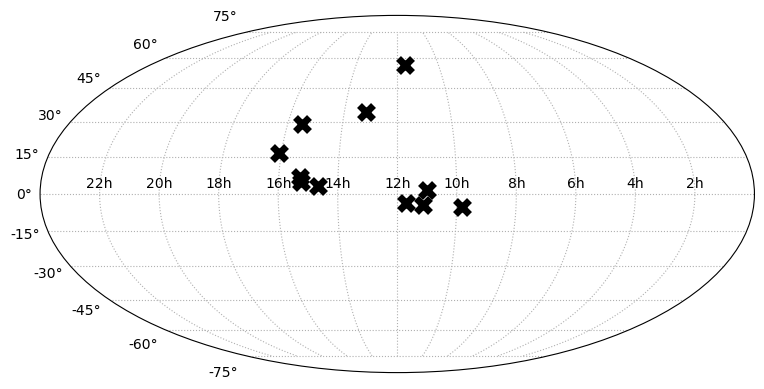

In [36]:
nest_ids = np.asarray(list(sga_clusters.keys()))
idx = np.isin(clusters['Nest'], nest_ids)
cluster_lon = clusters['SGLON'][idx]
cluster_lat = clusters['SGLAT'][idx]
cluster_coords = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in cluster_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':')

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_20241203.png', dpi=150)

In [37]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [38]:
def plot_cluster_members(clusters, cluster_id, cat, ids):
    """Generate a set of diagnostic plots for the members of a cluster.
    """
    
    #- Get cluster sky coordinates
    idx = np.isin(clusters["Nest"].values, cluster_id)
    cluster_lon = clusters["SGLON"].values[idx][0]
    cluster_lat = clusters["SGLAT"].values[idx][0]
    cluster_mu = clusters["DM"].values[idx][0]
    cluster_dist = 10 * 10 ** (0.2 * cluster_mu) * 1e-6
    cluster_v = H0 * cluster_dist
    cluster_sigma = clusters[sig_choice].values[idx][0]
    cluster_R2t = clusters["R2t"].values[idx][0]
    cluster_R2t_1p5 = np.arctan(1.5 * cluster_R2t / (cluster_v / H0)) * u.radian
    cluster_R2t_3 = np.arctan(3 * cluster_R2t / (cluster_v / H0)) * u.radian
    cluster_R2t_4 = np.arctan(4 * cluster_R2t / (cluster_v / H0)) * u.radian
    cluster_R2t_5 = np.arctan(5 * cluster_R2t / (cluster_v / H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')

    print(cluster_coord)
    print(f'{cluster_v} +/- {cluster_sigma} km/s')

    #- Get SGA galaxy coordinates and median of observations
    idx = np.isin(cat["SGA_ID"], ids)
    z = cat["Z_DESI"][idx]
    idy = np.isin(cat["SGA_ID"],duplicates)
    z_repeat = cat["Z_DESI"][idy]    
    zsel = (z_repeat*c_kms < (cluster_v + 4 * cluster_sigma)) & (z_repeat*c_kms> (cluster_v - 4 * cluster_sigma))

    z_median = np.median(z)   

    #  coords = SkyCoord(ra= cat['RA'][idx], dec= cat['DEC'][idx], unit='deg', frame='icrs')
    #  coords_median = cluster_median_coords( coords)
    coords = SkyCoord(
        ra=cat["RA"][idx], dec=cat["DEC"][idx], unit="deg", frame="icrs"
    )
    coords_repeat = SkyCoord(
        ra=cat["RA"][idy], dec=cat["DEC"][idy], unit="deg", frame="icrs"
    )
    rasel = (coords_repeat.ra < (cluster_coord.ra + cluster_R2t_5))&(coords_repeat.ra > (cluster_coord.ra - cluster_R2t_5))
    decsel = (coords_repeat.dec < (cluster_coord.dec + cluster_R2t_5))&(coords_repeat.dec > (cluster_coord.dec - cluster_R2t_5))

    coords_median = cluster_median_coords(coords)

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster_coord, radius=cluster_R2t_4)
    ax.grid()

    # ax.plot( coords.ra.deg,  coords.dec.deg, 'o', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster_id}')
    # ax.plot( coords_median.ra.deg,  coords_median.dec.deg, 'rD', transform=ax.get_transform('world'), ms=5, mew=5)
    # ax.plot(cluster_coord.ra.deg, cluster_coord.dec.deg, 'kx', transform=ax.get_transform('world'), ms=10, mew=5)
    ax.plot(
        coords.ra.deg, coords.dec.deg, "o", transform=ax.get_transform("world"), alpha=0.7, label=f"{cluster_id}",
    )
    
    # ax.plot(
    #     coords_repeat[zsel].ra.deg, coords_repeat[zsel].dec.deg, "o", color="r", transform=ax.get_transform("world"), markersize=3, label=f"{cluster_id}",
    # )
    
    ax.plot(        
        coords_median.ra.deg, coords_median.dec.deg, "bD", transform=ax.get_transform("world"), ms=5, mew=5,
    )
    ax.plot(
        cluster_coord.ra.deg, cluster_coord.dec.deg, "kx", transform=ax.get_transform("world"), ms=10, mew=5,
    )

    inner = SphericalCircle(cluster_coord, cluster_R2t_1p5, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner)

    outer = SphericalCircle(cluster_coord, cluster_R2t_3, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer)
    
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')

    #- Plot the Dec vs redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z, coords.dec.deg, "o", alpha=0.7, label=f"{cluster_id}")
    
    # ax.plot(z_repeat[rasel], coords_repeat[rasel].dec.deg, "o", c="r",markersize=3)
    
    ax.plot(z_median, coords_median.dec.deg, "bD", ms=5, mew=5)
    ax.plot(cluster_v / c_kms, cluster_coord.dec.deg, "kx", ms=10, mew=5)

    decmin = np.min(coords.dec.deg) - 0.5
    decmax = np.max(coords.dec.deg) + 0.5

    ax.vlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              decmin, decmax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           ylim=(decmin, decmax))

    #- Plot the RA vs redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(coords.ra.deg, z, "o", alpha=0.7, label=f"{cluster_id}")
    
    # ax.plot(coords_repeat[decsel].ra.deg, z_repeat[decsel], "o", c="r",markersize=3)
    
    ax.plot(coords_median.ra.deg, z_median, "bD", ms=5, mew=5)
    ax.plot(cluster_coord.ra.deg, cluster_v / c_kms, "kx", ms=10, mew=5)

    ramin = np.min( coords.ra.deg) - 0.5
    ramax = np.max( coords.ra.deg) + 0.5

    ax.hlines(np.asarray([cluster_v-3*cluster_sigma,
                          cluster_v+3*cluster_sigma,
                          cluster_v-2*cluster_sigma,
                          cluster_v+2*cluster_sigma])/c_kms,
              ramin, ramax,
              colors='tab:blue',
              linestyles=['solid', 'solid', 'dotted', 'dotted'])

    ax.set(ylabel='redshift',
           xlabel=r'$\alpha$ [deg]',
           xlim=(ramax, ramin))

    #- Histograms of RA, Dec, and redshift:
    delta_angle = 0.75
    
    ax = plt.subplot(234)
    ax.hist(coords.ra.deg, bins=np.arange(ramin, ramax+delta_angle, delta_angle))
    ax.axvline(coords_median.ra.deg, color="r", linestyle="dotted")
    ax.axvline(cluster_coord.ra.deg, color="k", linestyle="dotted")
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramax+delta_angle, ramin-delta_angle),
           ylabel='count',
           # ylim=(0,10)
          )

    ax = plt.subplot(235)
    ax.hist(coords.dec.deg, bins=np.arange(decmin, decmax+delta_angle, delta_angle))
    ax.axvline(coords_median.dec.deg, color="r", linestyle="dotted")
    ax.axvline(cluster_coord.dec.deg, color="k", linestyle="dotted")
    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmax+delta_angle, decmin-delta_angle),
           ylabel='count',
           # ylim=(0,10)
          )

    dz = 0.0025
    zmin = np.min(np.round(z, 2)) - 4*dz
    zmax = np.max(np.round(z, 2)) + 4*dz

    ax = plt.subplot(236)
    ax.hist(z, bins=np.arange(zmin, zmax + dz, dz))
    ax.axvline(z_median, color="r", linestyle="dotted")
    ax.axvline(cluster_v / c_kms, color="k", linestyle="dotted")
    ax.set(xlabel='redshift',
           xlim=(zmin, zmax),
           ylabel='count',
           # ylim=(0,10)
          )

    fig.suptitle(f'TF Iron Observations of Tully Group {cluster_id}')

    return fig

<SkyCoord (ICRS): (ra, dec) in deg
    (147.52854523, -5.17998222)>
6668.067692136219 +/- 303 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 326 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 2041 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (175.41038787, -3.83222093)>
17782.794100389227 +/- 2083 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 511 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 451 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (229.29825678, 7.14058993)>
10914.403364487573 +/- 620 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 763 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 1960 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1261 km/s
<Sk

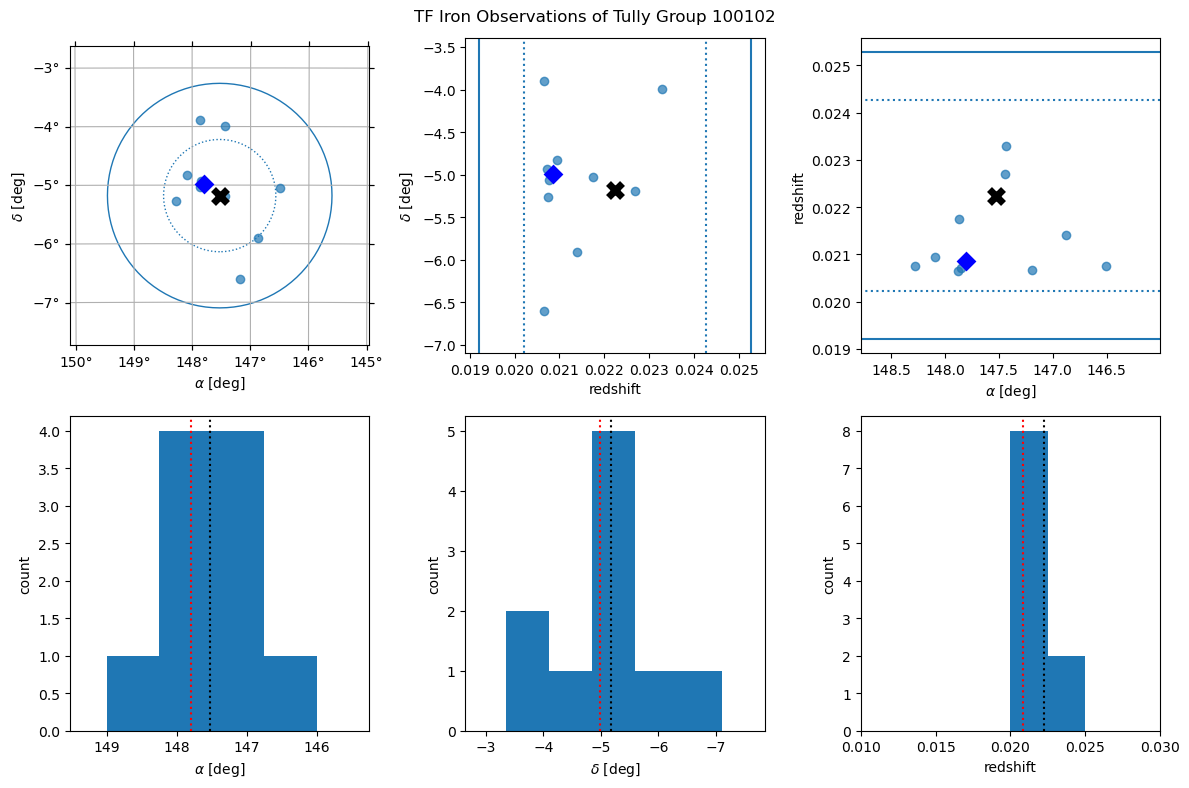

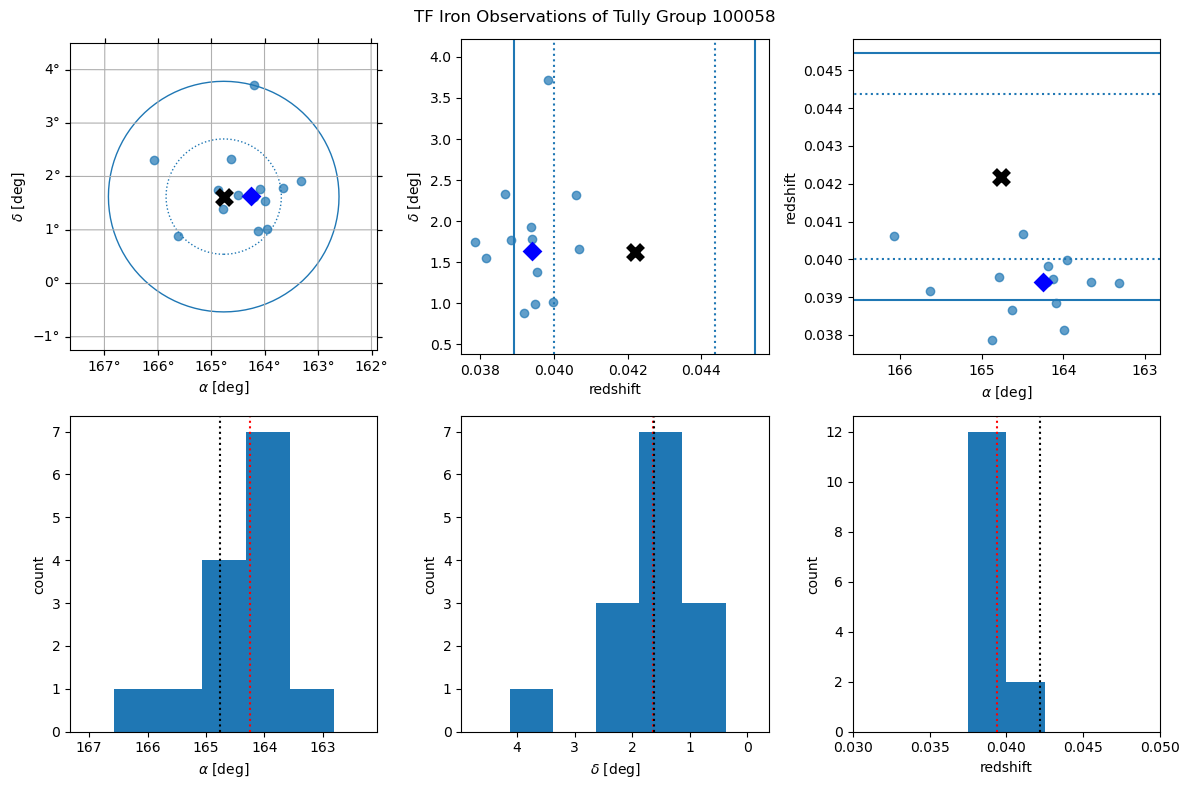

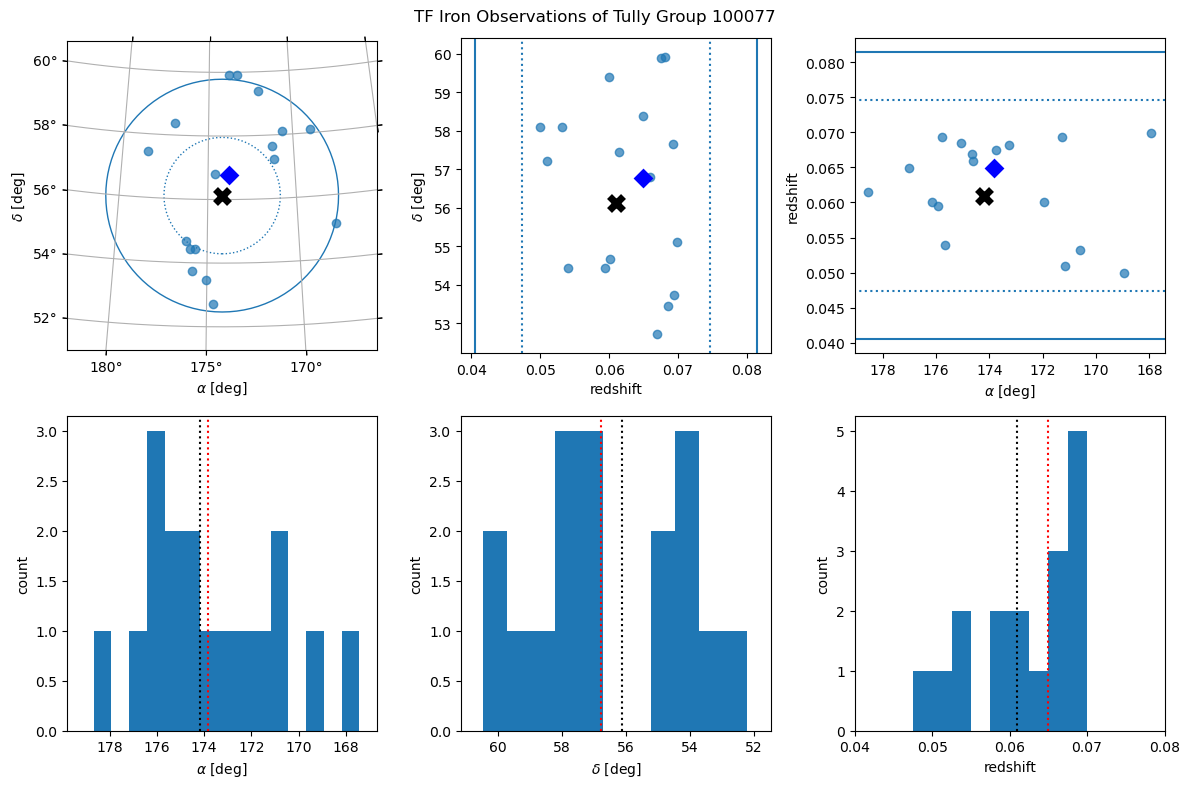

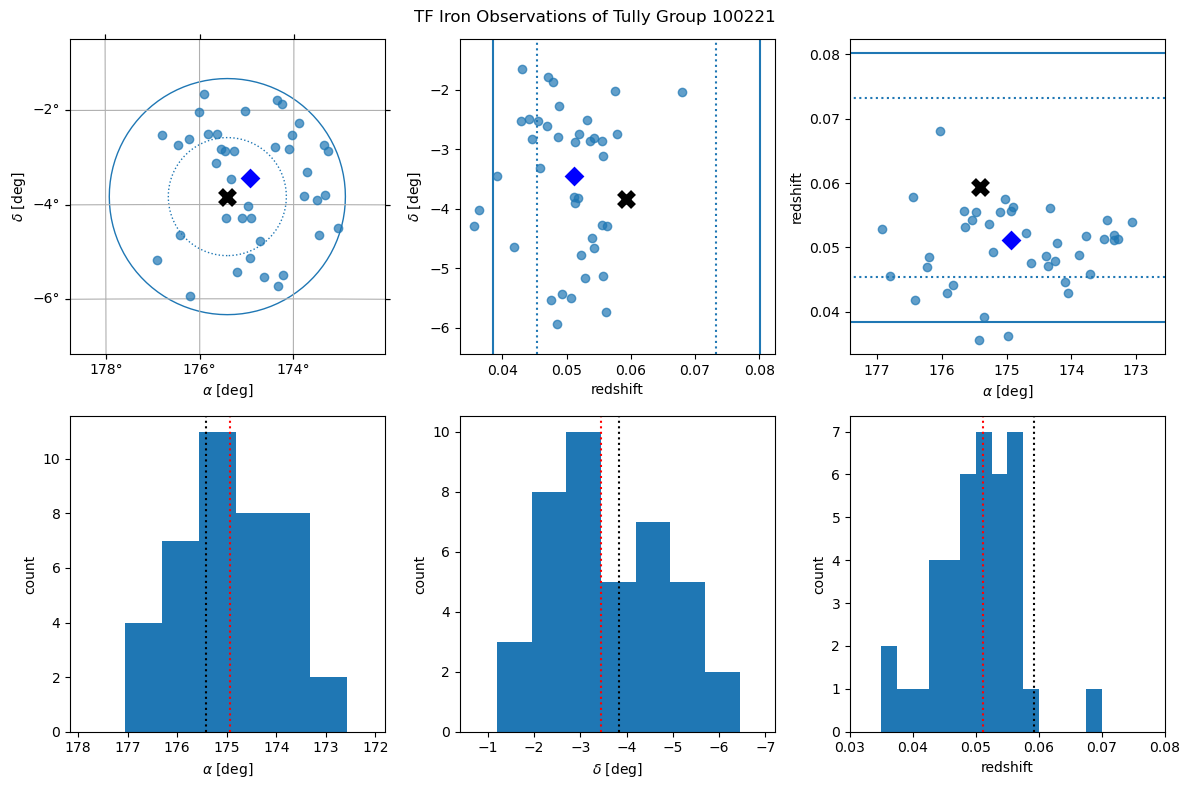

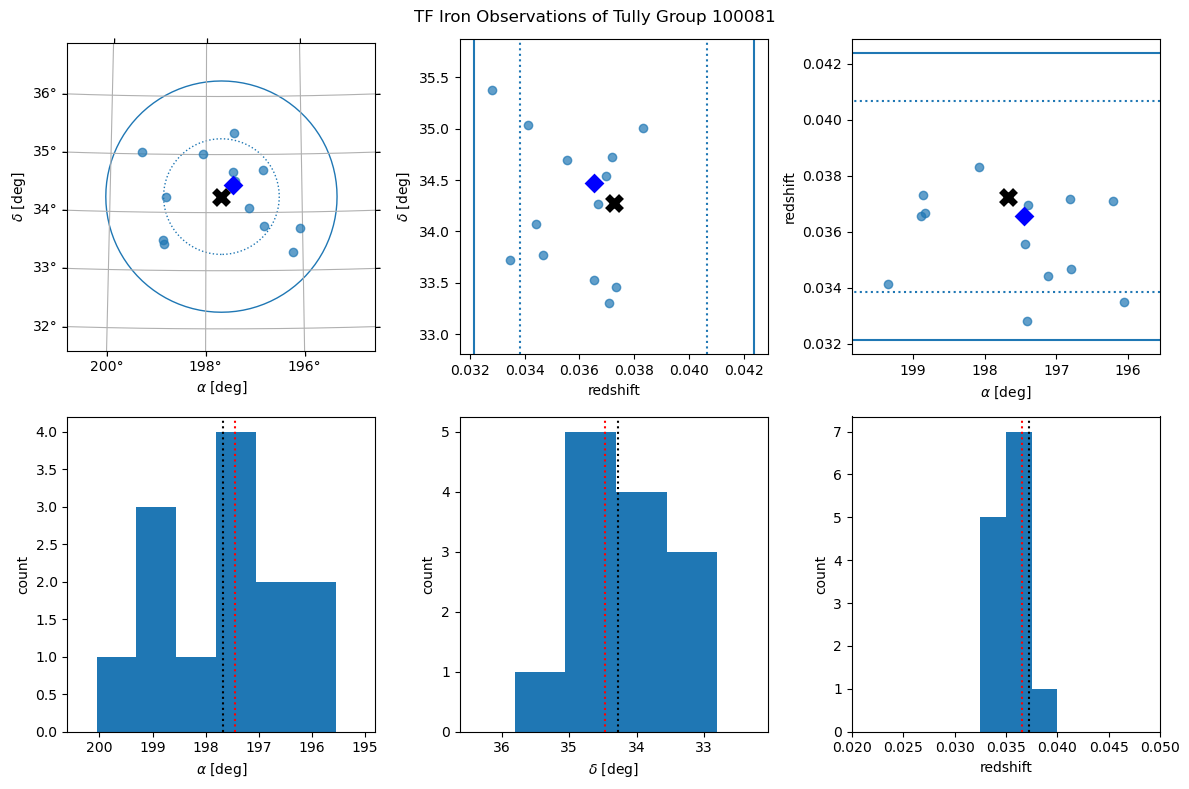

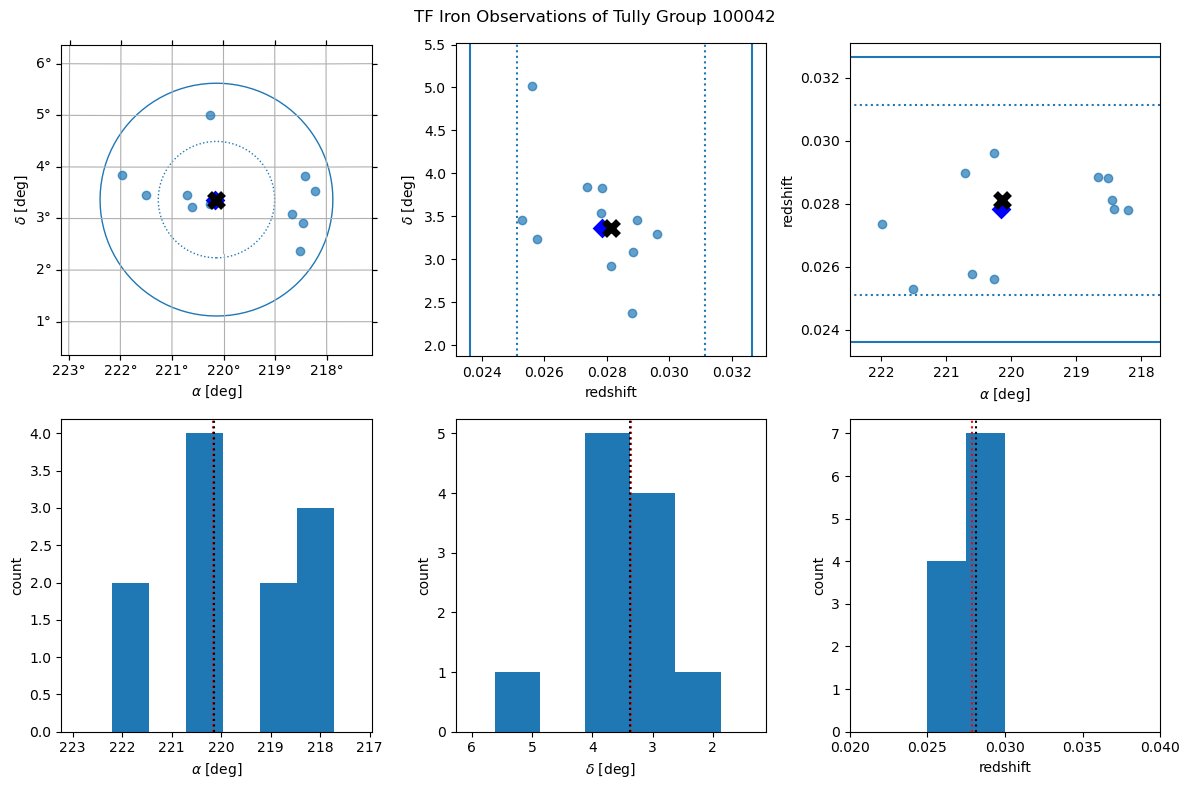

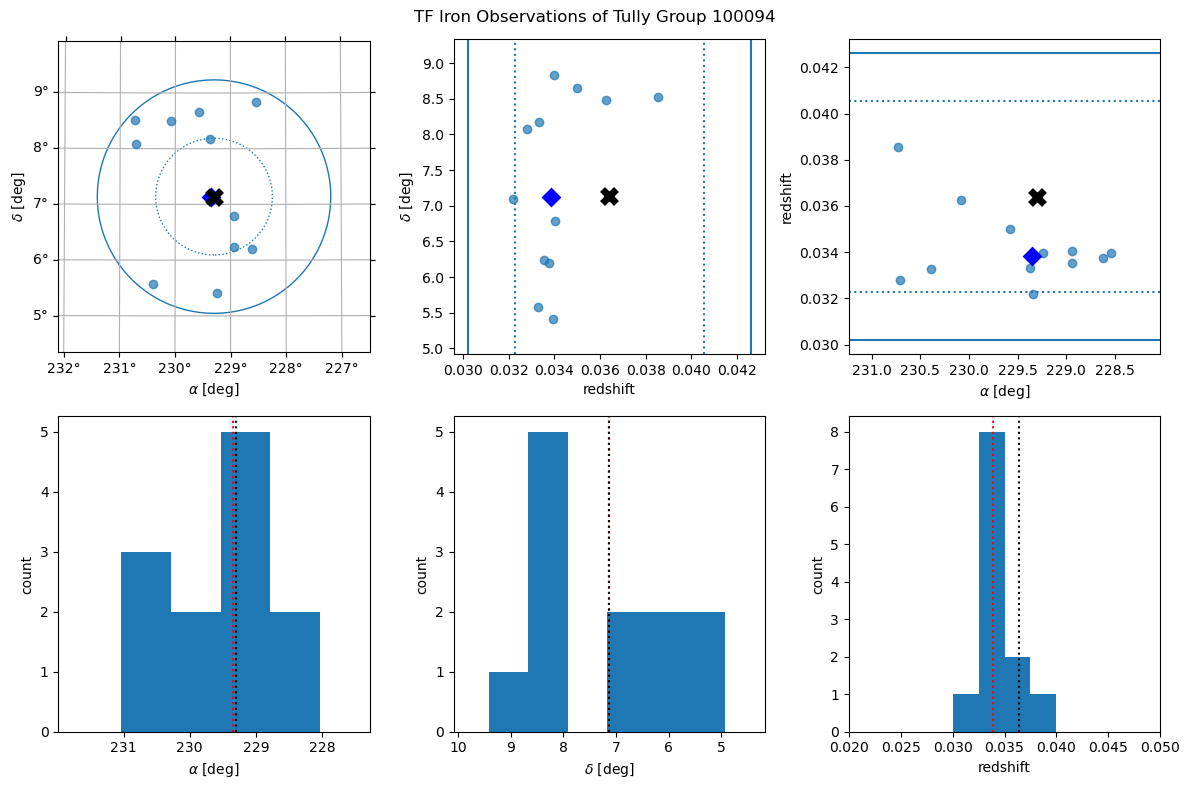

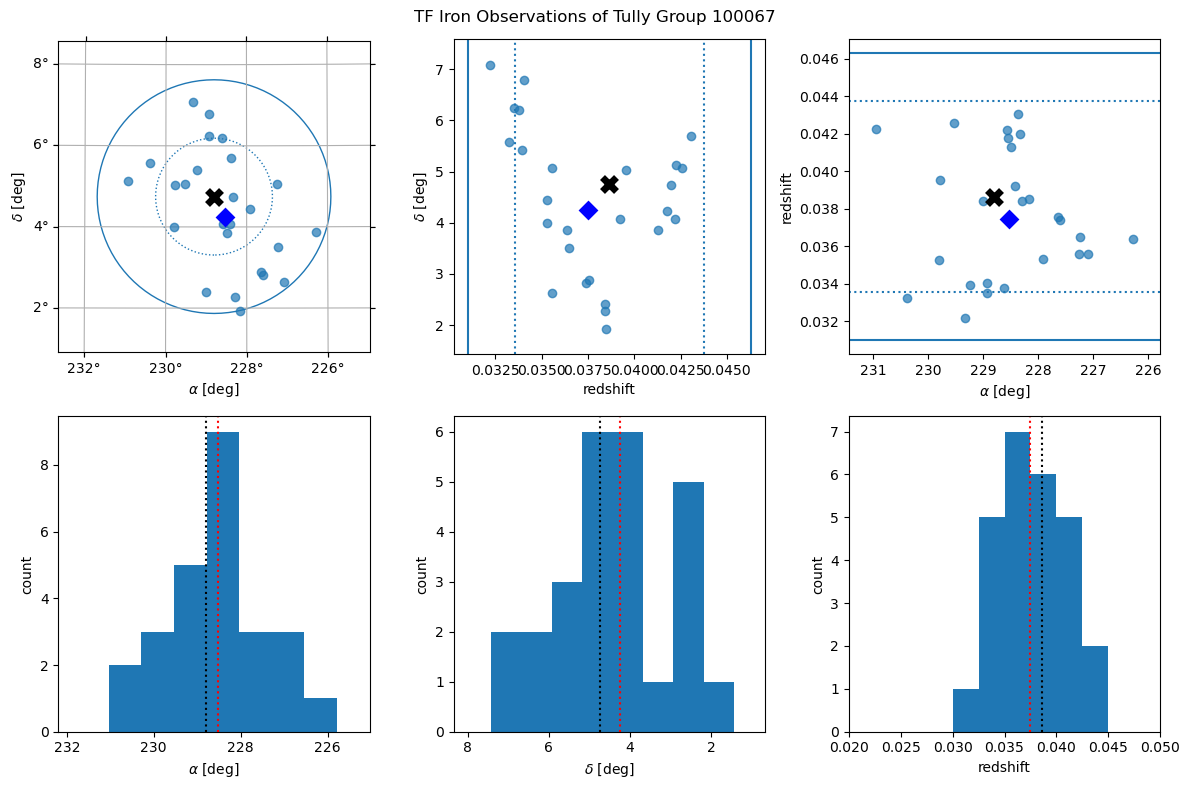

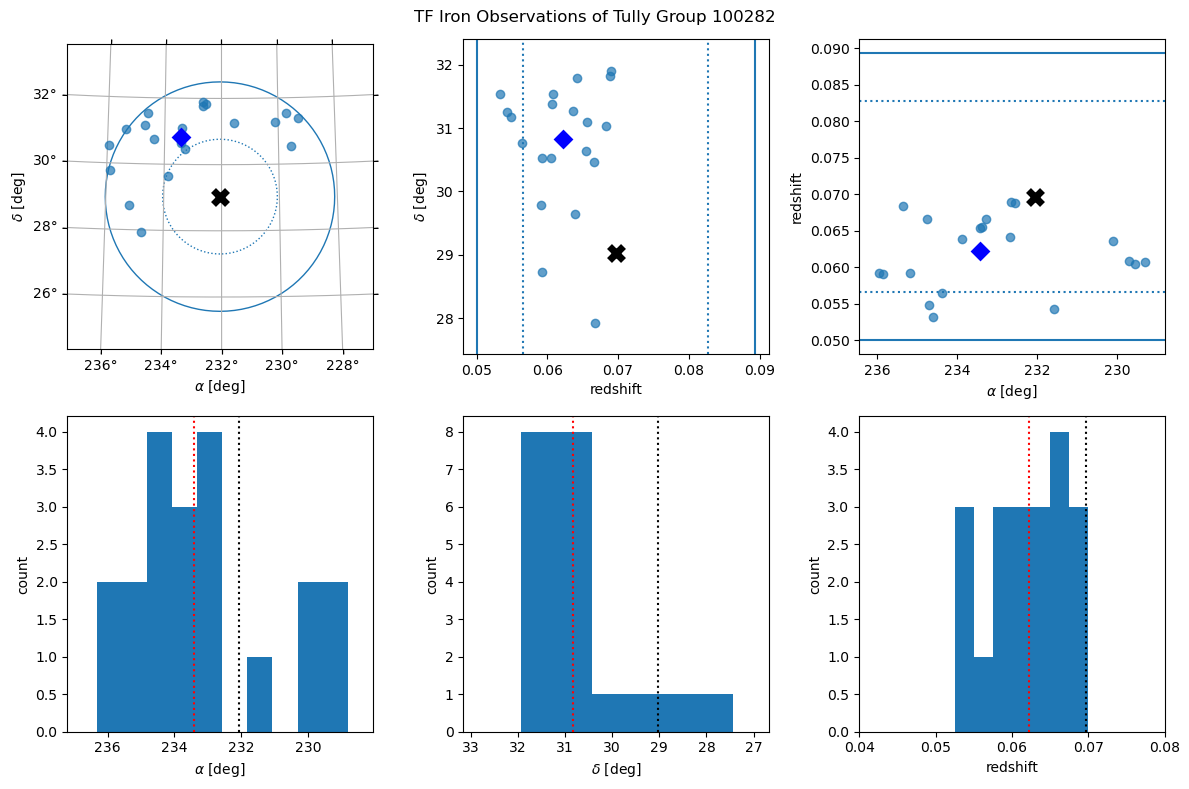

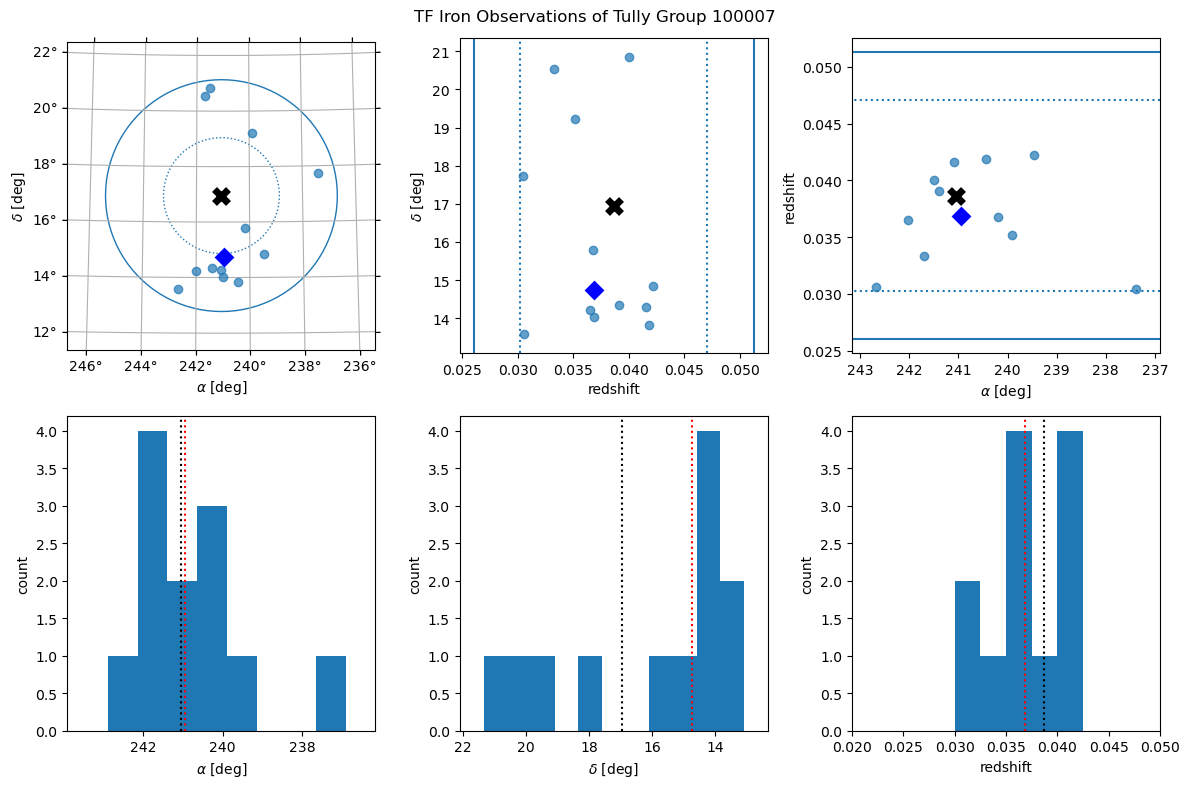

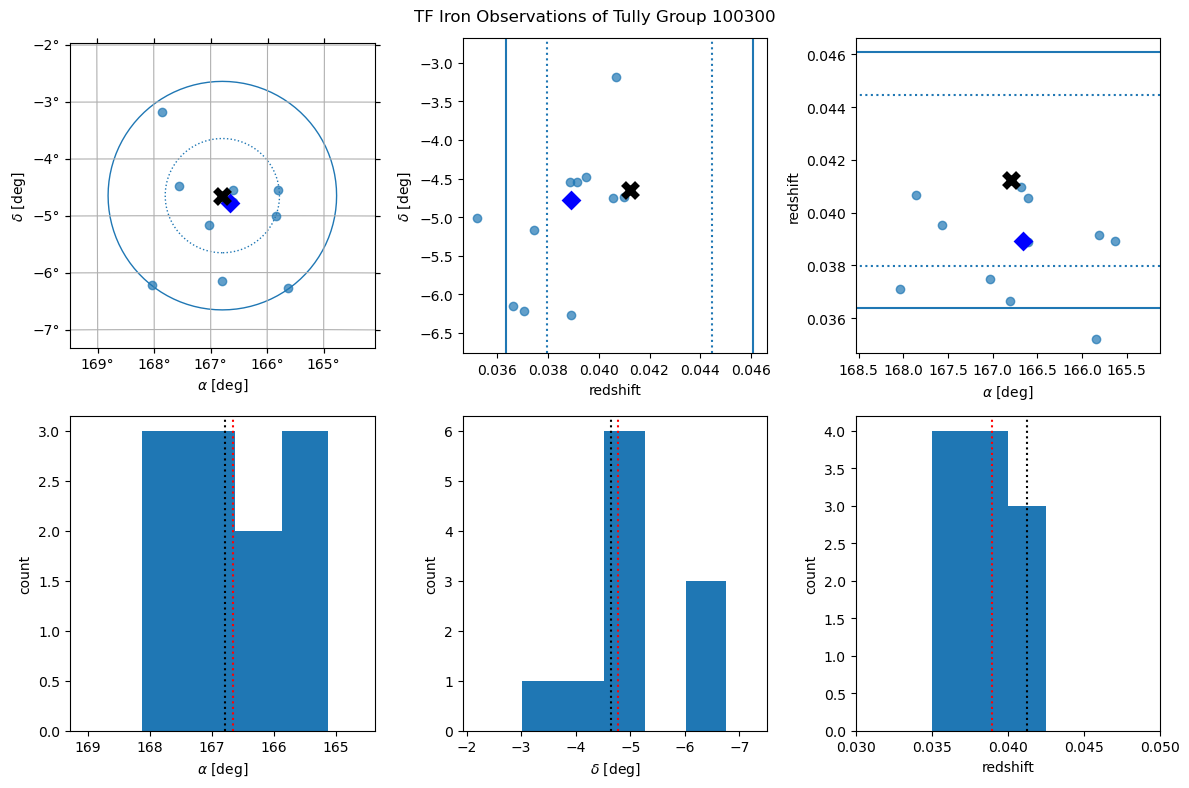

In [39]:
for cluster_id in sga_clusters.keys():
    fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])

# Apply Cluster Selection

Plot the clusters as a function of $\Delta\theta/\angle(R_{2t})$ versus $\Delta v/\sigma_P$. The quantities are:
* $\Delta\theta$: the angular separation between the median position of the DESI observations and the cluster center reported in Tully 2015.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster, reported in Tully 2015.

A reasonable selection appears to be

1. $\Delta v/ \sigma_P < 1$
2. $\Delta\theta / R_{2t} < 1$

100102       181.823 km/s     303.000 km/s       0.600       0.335 deg       0.653 deg       0.342
100058       324.281 km/s     326.000 km/s       0.995       0.515 deg       0.750 deg       0.458
100077      2227.143 km/s    2041.000 km/s       1.091       0.685 deg       1.295 deg       0.353
100221      1424.897 km/s    2083.000 km/s       0.684       0.617 deg       0.884 deg       0.465
100081       181.265 km/s     511.000 km/s       0.355       0.277 deg       0.688 deg       0.268
100042       137.797 km/s     451.000 km/s       0.306       0.026 deg       0.774 deg       0.022
100094       356.717 km/s     620.000 km/s       0.575       0.057 deg       0.724 deg       0.053
100067       227.110 km/s     763.000 km/s       0.298       0.568 deg       0.997 deg       0.380
100282       429.879 km/s    1960.000 km/s       0.219       2.153 deg       1.236 deg       1.161
100007       235.121 km/s    1261.000 km/s       0.186       2.219 deg       1.448 deg       1.021
100300    

[Text(0.5, 0, '$|\\Delta v|/\\sigma_P$'), (0.0, 1.5)]

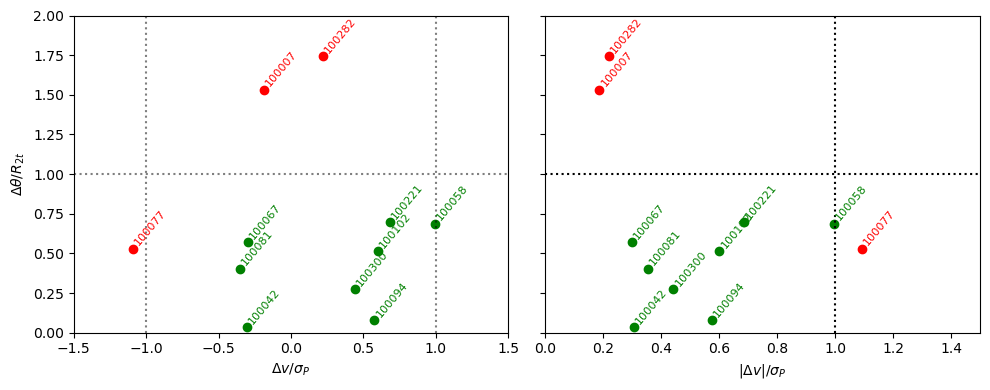

In [40]:
keep_cluster = []
dv_sigmaP = []
dtheta_R2t = []
cluster_ids = []

for cluster_id, sga_ids in sga_clusters.items():
    #- Get cluster sky coordinates
    idx = np.isin(clusters["Nest"].values, cluster_id)
    cluster_lon = clusters["SGLON"].values[idx][0]
    cluster_lat = clusters["SGLAT"].values[idx][0]
    # cluster_mu = clusters["DM"].values[idx][0]
    # cluster_dist = 10 * 10**(0.2*cluster_mu) * 1e-6
    # cluster_v = H0*cluster_dist
    cluster_v = 100.0 * 10**((clusters["DM"].values[idx][0]-25)/5.0) / (
        1+clusters["HRV"].values[idx][0]/c_kms)
    cluster_sigma = clusters[sig_choice].values[idx][0]
    cluster_R2t = clusters["R2t"].values[idx][0]
    cluster_R2t_angle = np.arctan(cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_1p5 = np.arctan(1.5*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_3 = np.arctan(3*cluster_R2t / (cluster_v/H0)) * u.radian
    cluster_R2t_4 = np.arctan(4*cluster_R2t / (cluster_v/H0)) * u.radian
    
    cluster_coord = SkyCoord(cluster_lon, cluster_lat, unit='deg', frame='supergalactic').transform_to('icrs')
    
    #- Get SGA galaxy coordinates and median of observations
    idx = np.isin(sgatab['SGA_ID'], sga_ids)
    z_sga = sgatab['Z_DESI'][idx]
    z_sorted = np.sort(z_sga)
    ngal = len(z_sorted)
    z_sga_median = np.mean(z_sorted[ngal//2:ngal//2 + 2]) if (ngal % 2 == 0) else z_sorted[ngal//2]
    
    sga_coords = SkyCoord(ra=sgatab['RA'][idx], dec=sgatab['DEC'][idx], unit='deg', frame='icrs')
    sga_coords_median = cluster_median_coords(sga_coords)

    #- Compute the angle and velocity ratios:
    delta_v = cluster_v - c_kms*z_sga_median
    _dv_sigP = delta_v / cluster_sigma
    dv_sigmaP.append(_dv_sigP)

    delta_theta = sga_coords_median.separation(cluster_coord).to('rad')
    _dth_R2t = delta_theta / cluster_R2t_angle
    dtheta_R2t.append(_dth_R2t)

    cluster_ids.append(cluster_id)

    #- Print results:
    print(f'{cluster_id:<8d}{np.abs(delta_v):12.3f} km/s{cluster_sigma:12.3f} km/s{np.abs(delta_v)/cluster_sigma:12.3f}' \
          f'{delta_theta.to("deg"):12.3f}{cluster_R2t_angle.to("deg"):12.3f}{delta_theta / (1.5*cluster_R2t_angle):12.3f}')

dv_sigmaP = np.asarray(dv_sigmaP)
dtheta_R2t = np.asarray(dtheta_R2t)
cluster_ids = np.asarray(cluster_ids)

#- Apply selection
dvcut = 1
dthcut = 1
select = (np.abs(dv_sigmaP) < dvcut) & (dtheta_R2t < dthcut)

#- Plot results

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True, tight_layout=True)
ax = axes[0]
ax.scatter(dv_sigmaP[select], dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(dv_sigmaP[select], dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(dv_sigmaP[~select], dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(dv_sigmaP[~select], dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k', alpha=0.5)
ax.axvline(-dvcut, ls=':', color='k', alpha=0.5)
ax.axhline(dthcut, ls=':', color='k', alpha=0.5)
ax.set(xlabel=r'$\Delta v/\sigma_P$',
       xlim=(-1.5, 1.5),
       ylabel=r'$\Delta\theta/R_{2t}$',
       ylim=(0,2))

ax = axes[1]
ax.scatter(np.abs(dv_sigmaP[select]), dtheta_R2t[select], color='g')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[select]), dtheta_R2t[select], cluster_ids[select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='green')

ax.scatter(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], color='r')
for _dv, _dth, _id in zip(np.abs(dv_sigmaP[~select]), dtheta_R2t[~select], cluster_ids[~select]):
    ax.annotate(f'{_id}', (_dv, _dth+0.02), fontsize=8, rotation=50, color='red')

ax.axvline(dvcut, ls=':', color='k')
ax.axvline(-dvcut, ls=':', color='k')
ax.axhline(dthcut, ls=':', color='k')
ax.set(xlabel=r'$|\Delta v|/\sigma_P$',
       xlim=(0, 1.5))

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_clusters_selection_binaryMLupdated_20241023.png', dpi=150)

In [41]:
nest_ids = np.asarray(list(sga_clusters.keys()))
good_idx = np.isin(clusters["Nest"].values, nest_ids[select])
bad_idx = np.isin(clusters["Nest"].values, nest_ids[~select])
good_cluster_coords = SkyCoord(
    clusters["SGLON"].values[good_idx],
    clusters["SGLAT"].values[good_idx],
    unit="deg",
    frame="supergalactic",
)
bad_cluster_coords = SkyCoord(
    clusters["SGLON"].values[bad_idx],
    clusters["SGLAT"].values[bad_idx],
    unit="deg",
    frame="supergalactic",
)

# ax = init_sky()

# ax.scatter(ax.projection_ra(bad_cluster_coords.transform_to('icrs').ra.value), 
#            ax.projection_dec(bad_cluster_coords.transform_to('icrs').dec.value), 
#            marker='x', 
#            s=100,
#            linewidth=2,
#            color='gray', 
#            label='rejected clusters')
# ax.scatter(ax.projection_ra(good_cluster_coords.transform_to('icrs').ra.value), 
#            ax.projection_dec(good_cluster_coords.transform_to('icrs').dec.value), 
#            marker='x', 
#            s=100,
#            linewidth=5,
#            color='black', 
#            label='DESI DR1')

# ax.xaxis.label.set_size(14)
# ax.yaxis.label.set_size(14)

# plt.legend(loc='lower right')

# plt.tick_params(axis='both', which='major', labelsize=12)

# # plt.savefig('../../Figures/Y1/iron_clusters_sky.png', dpi=150, facecolor='none')

In [42]:
for i, (cluster_id, sga_ids) in enumerate(sga_clusters.items()):
    print(f'{i+1:2d} {cluster_id:7d} {len(sga_ids):3d} galaxies  {"Y" if select[i] else "N"}')

 1  100102  10 galaxies  Y
 2  100058  14 galaxies  Y
 3  100077  17 galaxies  N
 4  100221  40 galaxies  Y
 5  100081  13 galaxies  Y
 6  100042  11 galaxies  Y
 7  100094  12 galaxies  Y
 8  100067  26 galaxies  Y
 9  100282  20 galaxies  N
10  100007  12 galaxies  N
11  100300  11 galaxies  Y


## Plot Galaxy Clusters that Failed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (174.18925473, 56.12464342)>
18281.002161427445 +/- 2041 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (232.05444778, 29.03388829)>
20892.961308540405 +/- 1960 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (241.05808519, 16.95441739)>
11587.773561551261 +/- 1261 km/s


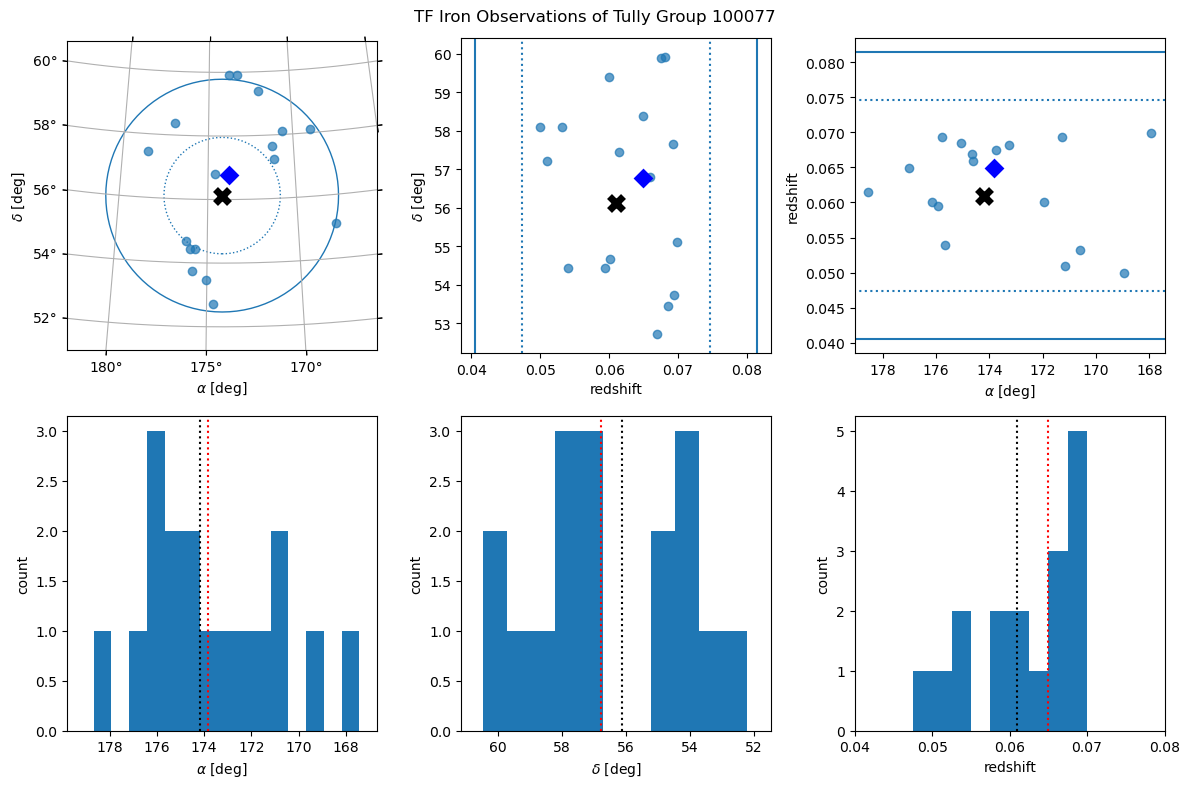

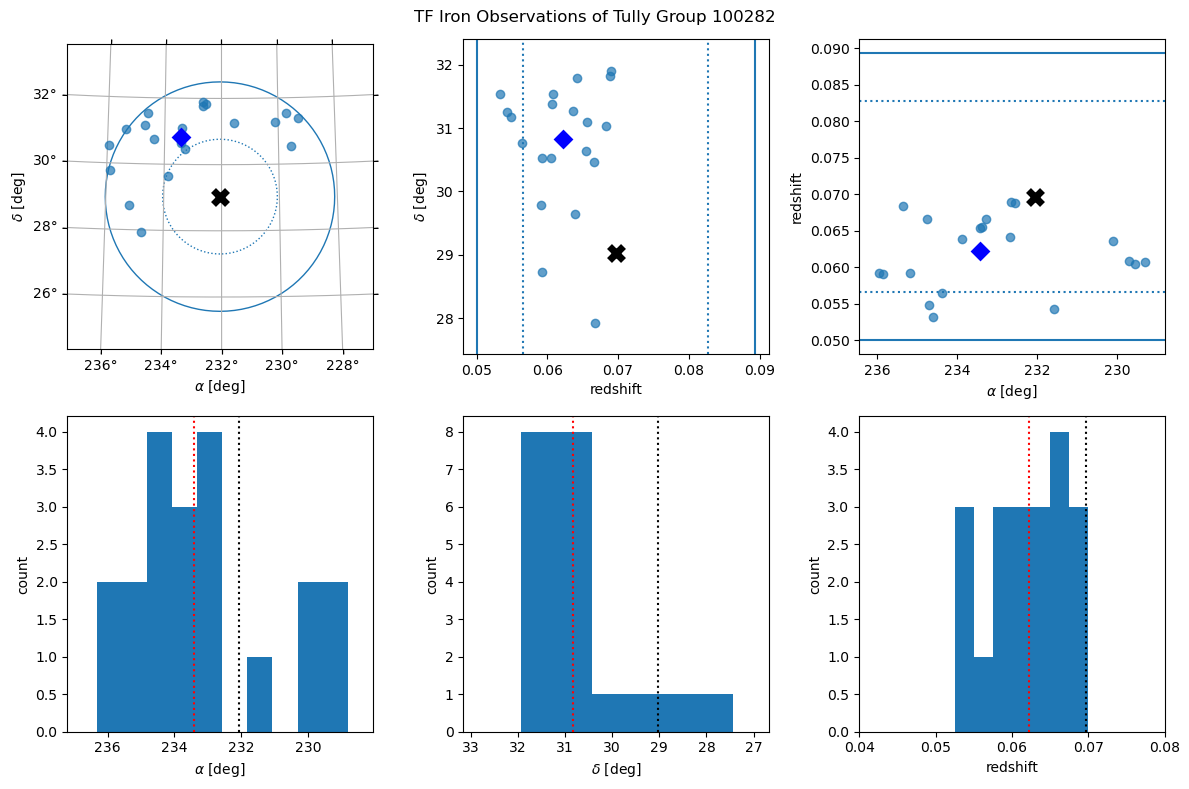

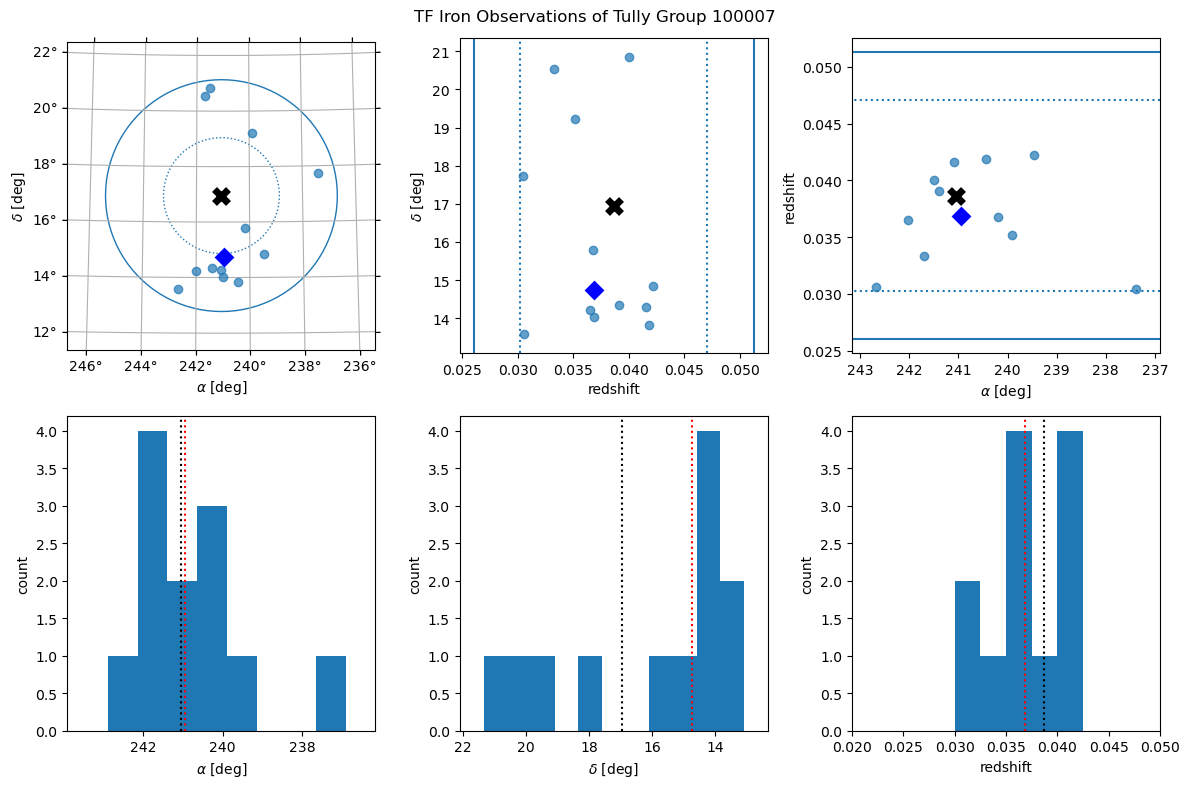

In [43]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[~select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150)

## Plot Galaxy Clusters that Passed the Selection

<SkyCoord (ICRS): (ra, dec) in deg
    (147.52854523, -5.17998222)>
6668.067692136219 +/- 303 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (164.76646719, 1.62439612)>
12647.363474711521 +/- 326 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (175.41038787, -3.83222093)>
17782.794100389227 +/- 2083 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (197.68010565, 34.27637749)>
11168.632477805635 +/- 511 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (220.13676059, 3.3706831)>
8433.347577642775 +/- 451 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (229.29825678, 7.14058993)>
10914.403364487573 +/- 620 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (228.80657754, 4.74840124)>
11587.773561551261 +/- 763 km/s
<SkyCoord (ICRS): (ra, dec) in deg
    (166.79383597, -4.64785571)>
12359.474334445118 +/- 485 km/s


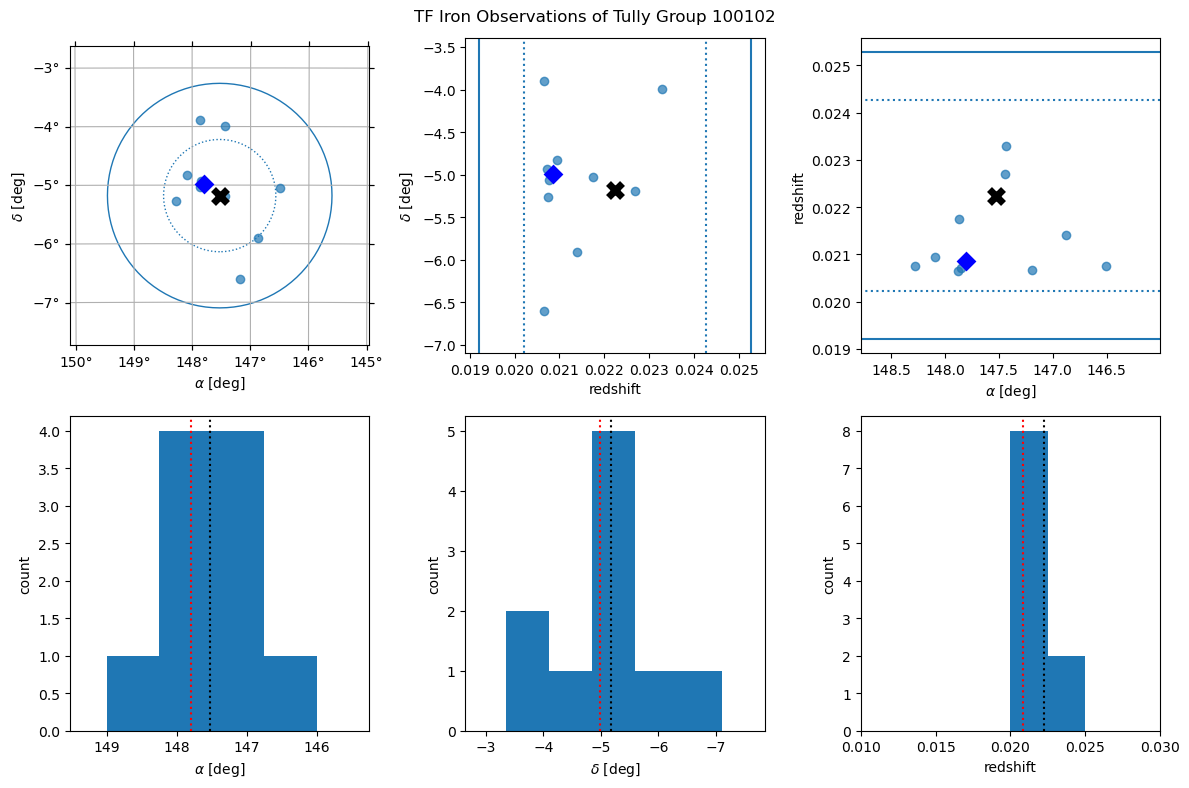

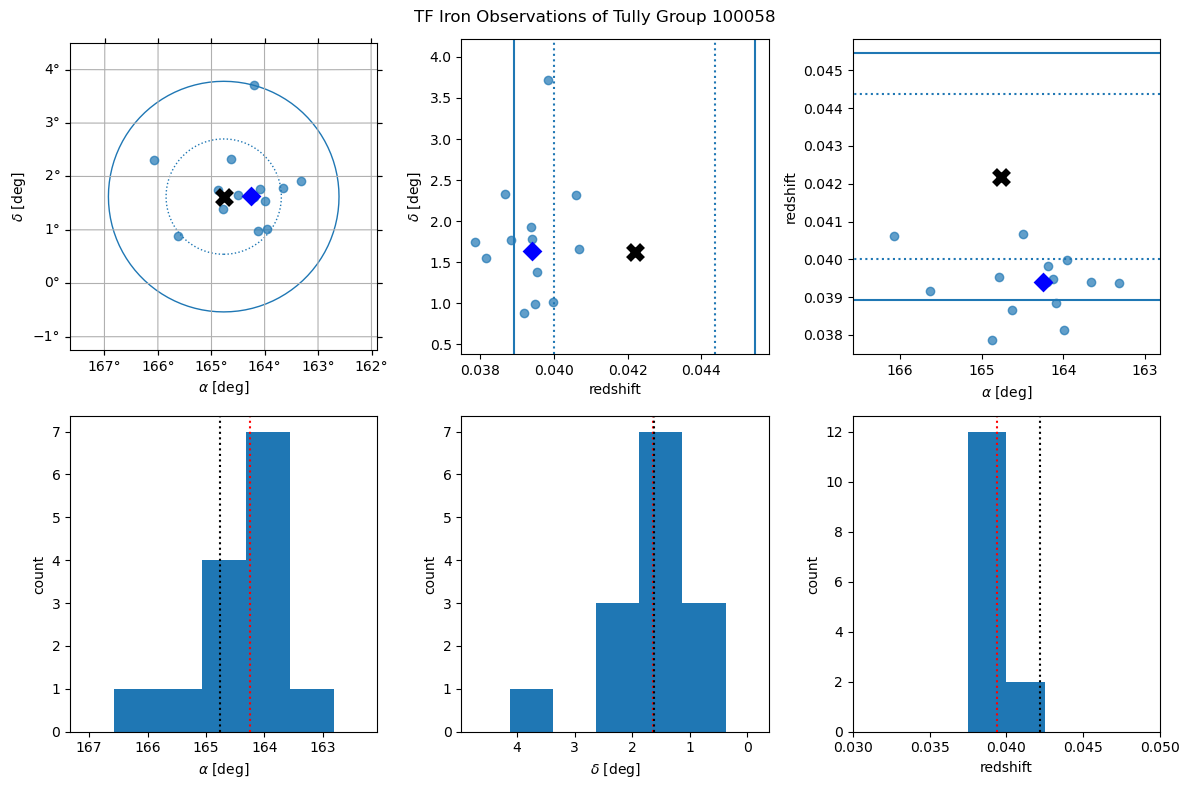

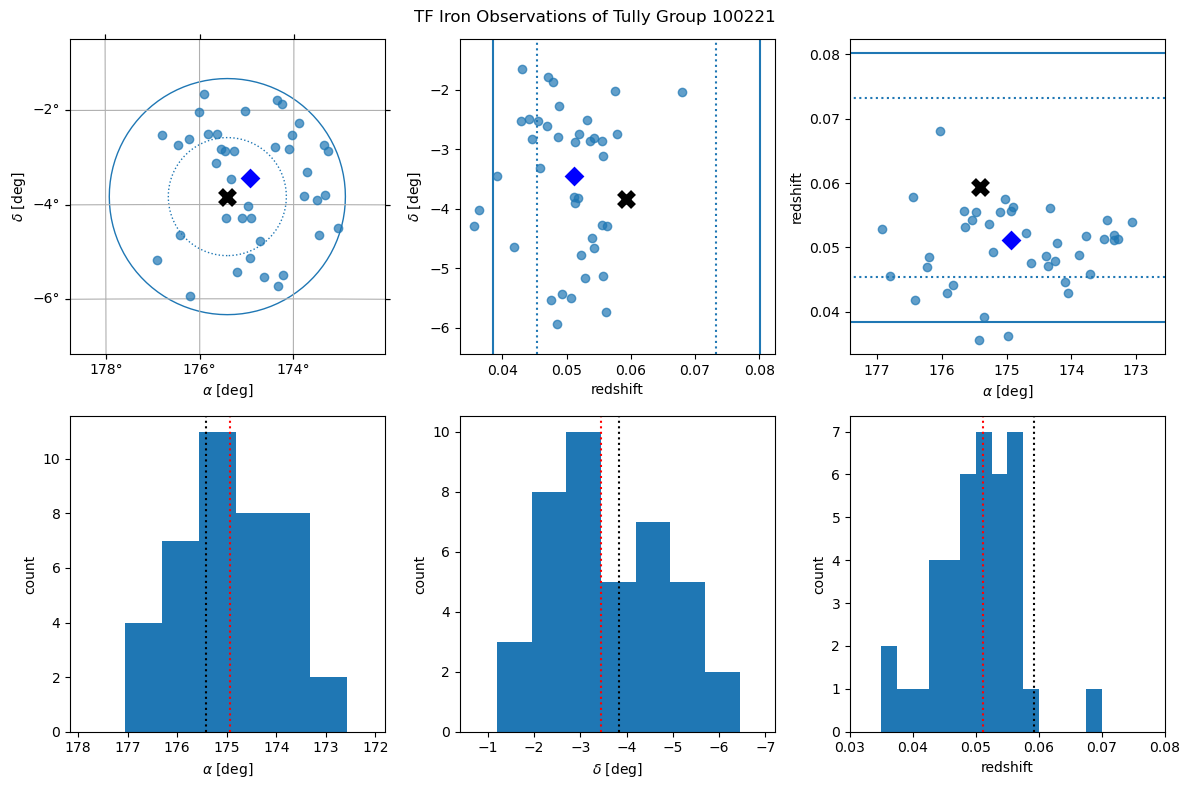

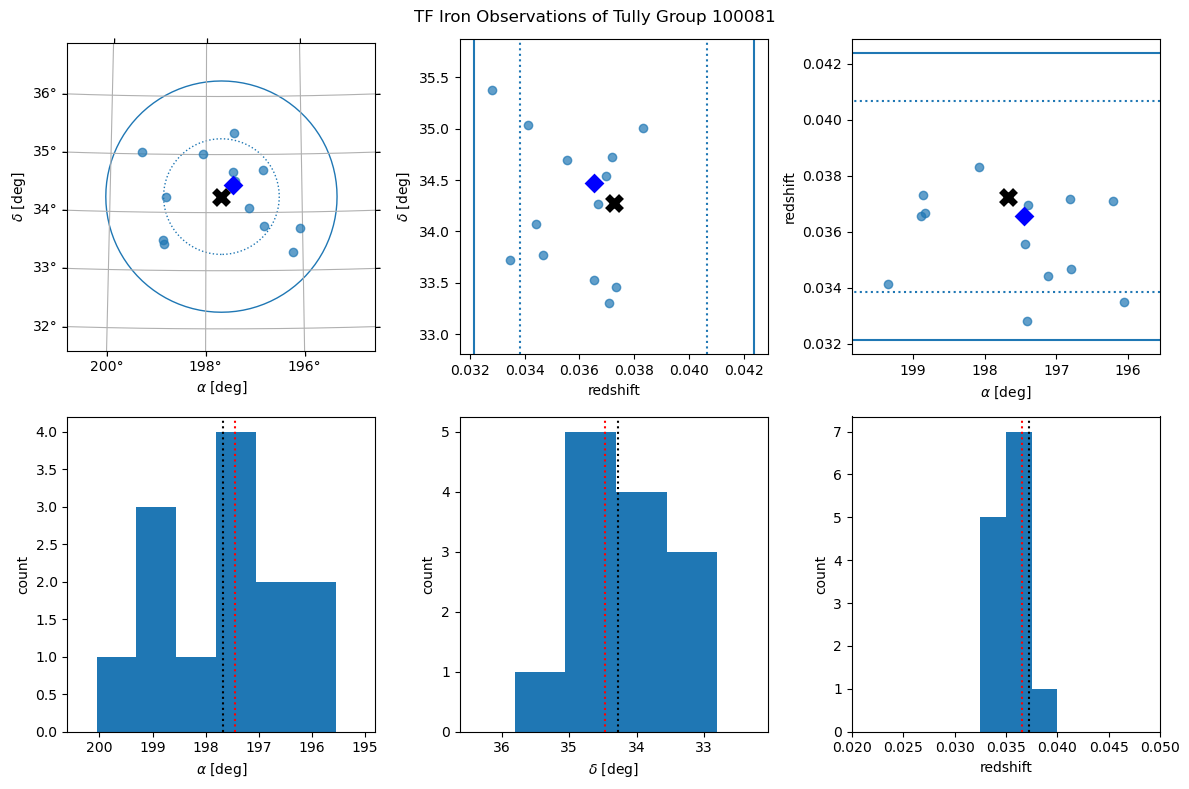

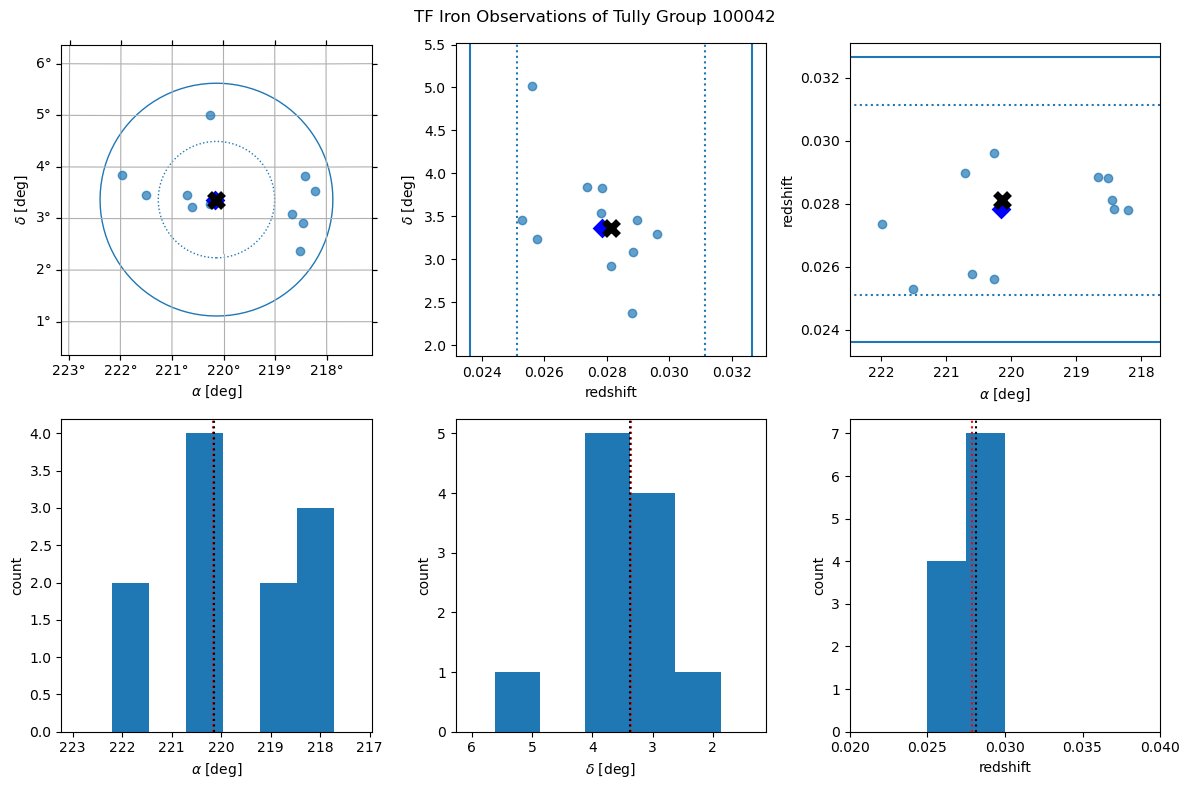

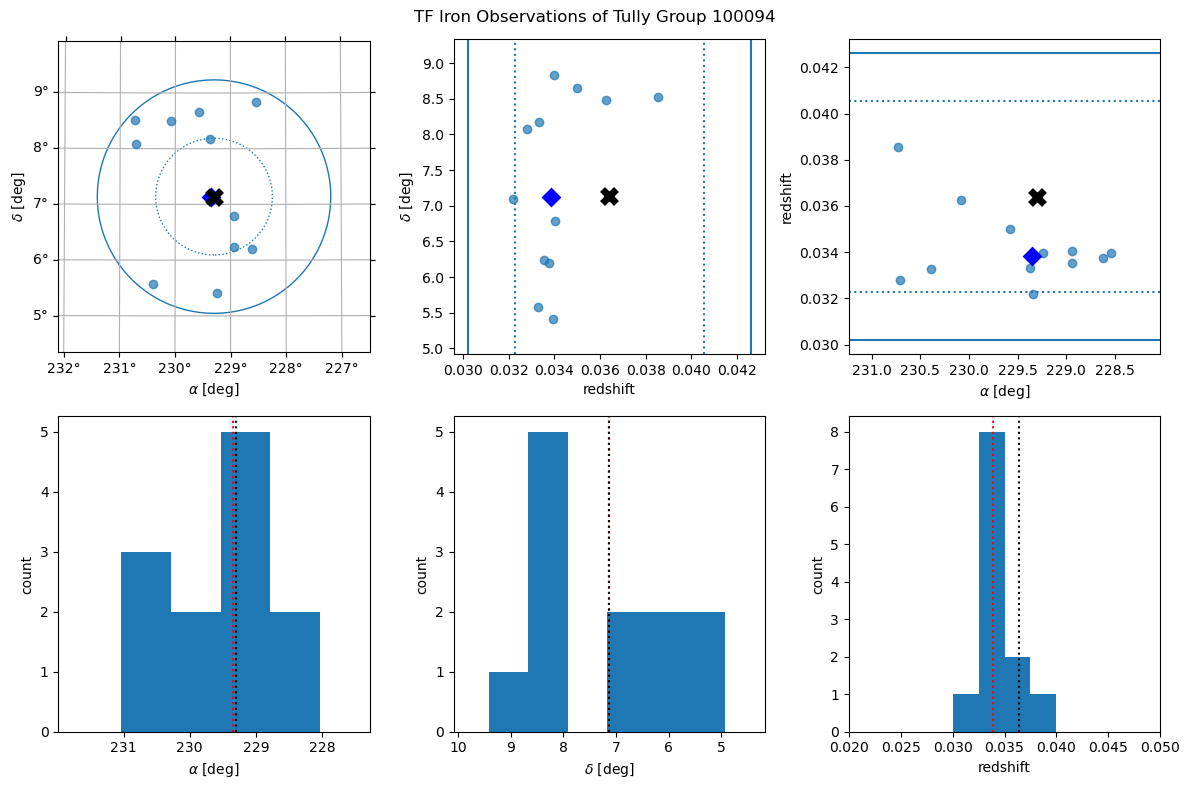

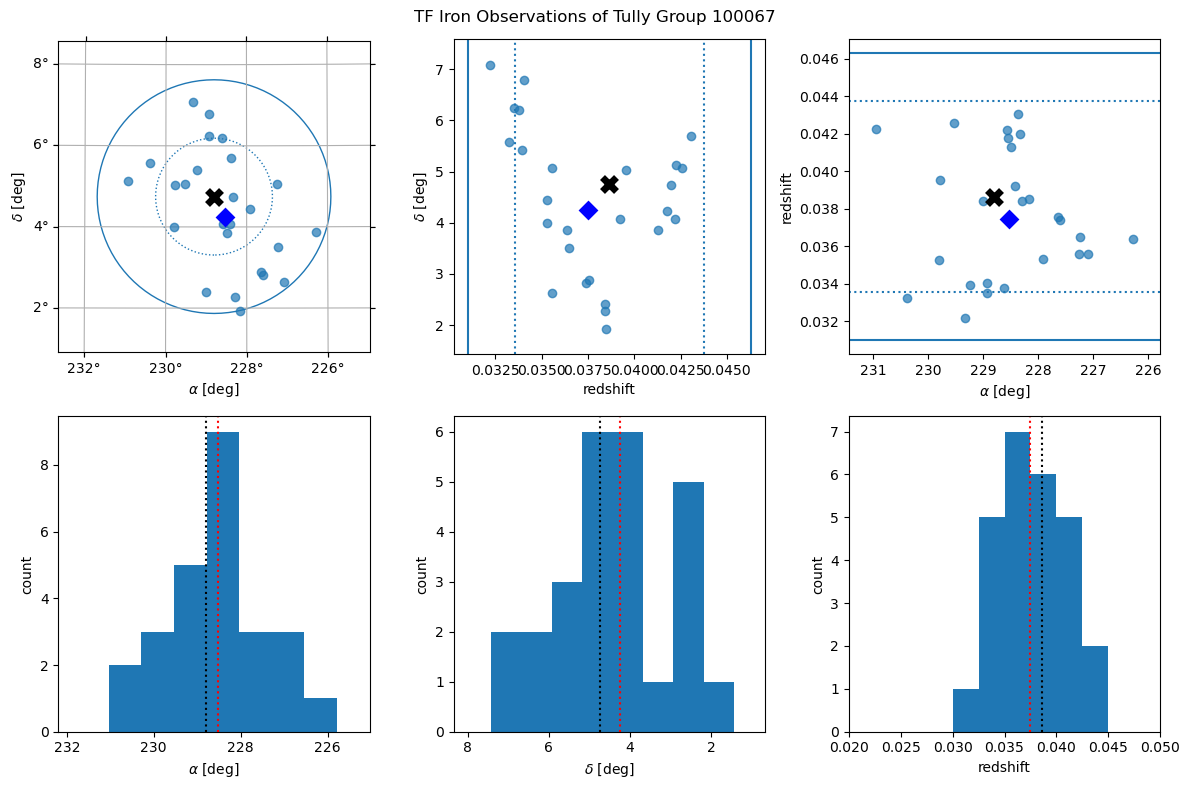

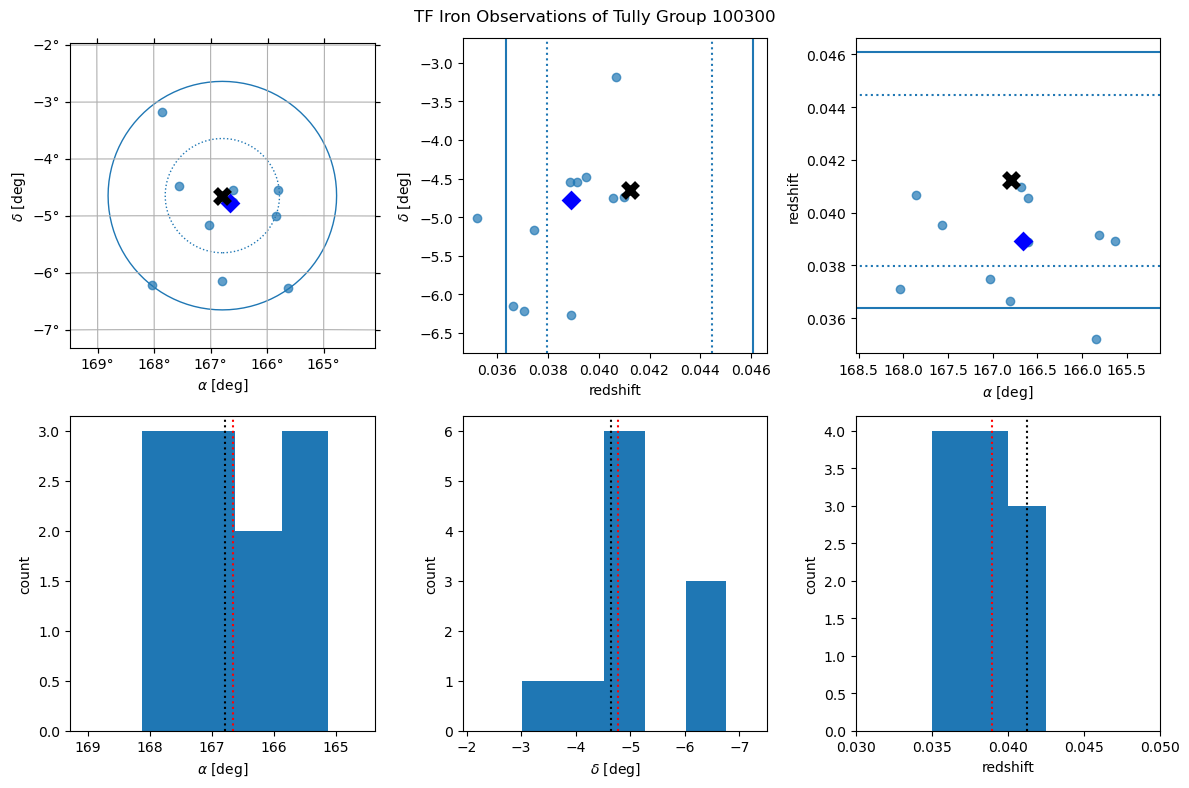

In [44]:
for cluster_id in sga_clusters.keys():
    if cluster_id in cluster_ids[select]:
        fig = plot_cluster_members(clusters, cluster_id, sgatab_sel, sga_clusters[cluster_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150)

# Build the Calibration Table of SGA Galaxies in Clusters

In [45]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for cluster_id, sga_ids in sga_clusters.items():
    if cluster_id in cluster_ids[select]:
        idx = np.isin(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        caltab = clustertab if caltab is None else vstack([caltab, clustertab])
    else:
        idx = np.isin(sgatab['SGA_ID'], sga_ids)
        clustertab = sgatab[idx]
        clustertab['CLUSTER_ID'] = cluster_id
        
        rejtab = clustertab if rejtab is None else vstack([rejtab, clustertab])

caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)
caltab[['CLUSTER_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']]

<Table length=137>
CLUSTER_ID   SGA_ID  ...      V_0p4R26         V_0p4R26_err   
  int64     float64  ...      float64            float64      
---------- --------- ... ------------------ ------------------
    100102  413420.0 ...  56.49570854422659 1.3225000128917097
    100102  422578.0 ... 59.909698624864895 0.8980718582902978
    100102  438979.0 ... 101.50200498736045 1.3814547899557257
    100102  509259.0 ...   90.5013838615217  6.749364945778493
    100102  610187.0 ...  36.78469340958109 10.514978599638606
    100102  712425.0 ...  47.06120898103195  17.77225681269355
    100102  789070.0 ... 231.05090663789318  1.654195804610258
    100102  888156.0 ... 121.28245815173214 0.9818442756954492
    100102 1076076.0 ... 30.838793270031672  67.12344110836874
       ...       ... ...                ...                ...
    100300  132794.0 ... 175.09598153848262  6.839972555070058
    100300  174618.0 ... 243.31000789031873  4.185774866116798
    100300  508915.0 ...  77.67256132424886 2.0202429636353902
    100300  674664.0 ... 108.15621844197231 2.9129220081398164
    100300  689708.0 ... 145.70233225389336  4.459357884176021
    100300  853654.0 ... 186.92201832396182 0.7642399794171514
    100300  965774.0 ... 111.93604331739839  4.303858581230948
    100300 1041409.0 ... 167.12922001689284 16.676995822751476
    100300 1338226.0 ... 224.71836950691298  4.284335093593857
    100300 1432989.0 ... 120.05521214813423  3.272133552740327

In [46]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
caltab['SGA_ID'] = np.int32(caltab['SGA_ID'])

for cluster in np.unique(caltab['CLUSTER_ID']):
    output_filename = 'output_' + str(cluster) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['CLUSTER_ID'] == cluster].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [47]:
rejtab

<Table length=49>
  SGA_ID     SGA_GALAXY    ... R_MAG_SB26_ERR_CORR CLUSTER_ID
 float64      bytes16      ...       float64         int64   
--------- ---------------- ... ------------------- ----------
  25599.0   SGA-2020 25599 ... 0.12313163901593156     100077
 102526.0  SGA-2020 102526 ... 0.12359078124665379     100077
 112080.0  SGA-2020 112080 ... 0.12042115523943765     100077
 116641.0  SGA-2020 116641 ... 0.08931141644627015     100077
 394983.0  SGA-2020 394983 ... 0.13300670585805527     100077
 455657.0  SGA-2020 455657 ... 0.14984211987299081     100077
 533364.0  SGA-2020 533364 ... 0.07397602687606643     100077
 756946.0  SGA-2020 756946 ... 0.16602516394309372     100077
 758015.0  SGA-2020 758015 ...  0.1587597335086669     100077
      ...              ... ...                 ...        ...
 294344.0  SGA-2020 294344 ...  0.0967063607469942     100007
 295688.0  SGA-2020 295688 ... 0.17304217876215514     100007
 364205.0  SGA-2020 364205 ...  0.1698245871208175     100007
 378878.0  SGA-2020 378878 ... 0.11226743153035004     100007
 547663.0  SGA-2020 547663 ... 0.06102251503512211     100007
 557038.0  SGA-2020 557038 ...   0.188769617576566     100007
 841535.0  SGA-2020 841535 ...  0.1709189351929151     100007
 842600.0  SGA-2020 842600 ...  0.1658754838228405     100007
1190077.0 SGA-2020 1190077 ... 0.10287391852972605     100007
1354164.0 SGA-2020 1354164 ... 0.09305662074984888     100007

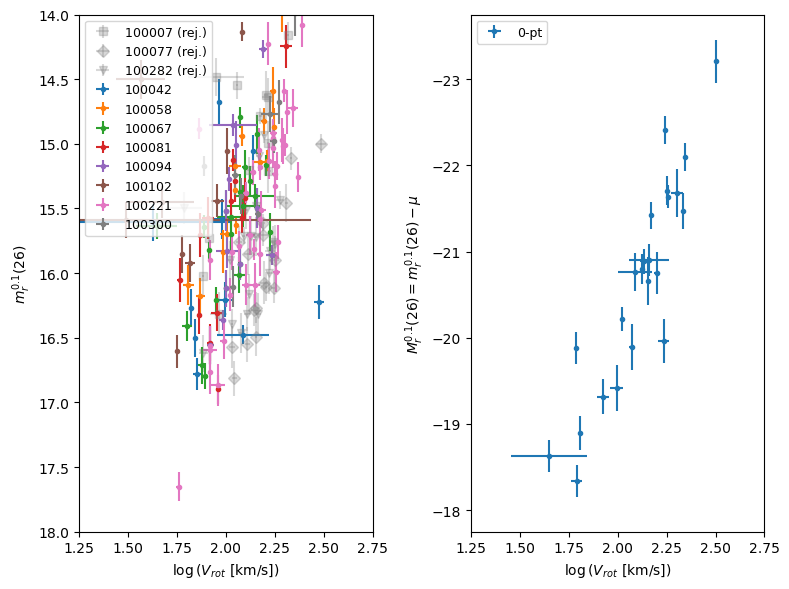

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#- Plot galaxies with failed cluster selections.
_cluster_ids = np.unique(rejtab['CLUSTER_ID'])
markers = 'sDv^<>'
for j, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.isin(rejtab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_err'][select_cluster].data / rejtab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_cluster_id} (rej.)')

#- Plot galaxies and clusters passing all selections.
_cluster_ids = np.unique(caltab['CLUSTER_ID'])

for _cluster_id in _cluster_ids:
    select_cluster = np.isin(caltab['CLUSTER_ID'], _cluster_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_cluster].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_cluster].data / caltab['V_0p4R26'][select_cluster].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_cluster].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_cluster].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_cluster_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18, 14],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150)

# Apply the Joint TFR Fit

In [49]:
#- Extract successful clusters
_cluster_ids = np.unique(caltab['CLUSTER_ID'])
m = len(_cluster_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA clusters
for k, _cluster_id in enumerate(_cluster_ids):
    select_cluster = np.isin(caltab['CLUSTER_ID'], _cluster_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_cluster]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_cluster] / caltab['V_0p4R26'][select_cluster])
    mag.append(caltab['R_MAG_SB26_CORR'][select_cluster])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_cluster])

logV0 = 2.08019601883192


## Multiline Fit using HyperFit

In [50]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -6598.383627100428
                   x: [-6.769e+00 -2.041e+01  1.540e+01  1.531e+01
                        1.541e+01  1.510e+01  1.547e+01  1.410e+01
                        1.601e+01  1.548e+01  6.277e-01]
                 nit: 115
                nfev: 19308
          population: [[-6.767e+00 -2.041e+01 ...  1.548e+01  6.274e-01]
                       [-6.772e+00 -2.041e+01 ...  1.547e+01  6.288e-01]
                       ...
                       [-6.771e+00 -2.041e+01 ...  1.547e+01  6.275e-01]
                       [-6.762e+00 -2.041e+01 ...  1.547e+01  6.274e-01]]
 population_energies: [-6.598e+03 -6.598e+03 ... -6.598e+03 -6.598e+03]
                 jac: [ 1.128e-02  3.565e-02  1.455e-03 -4.184e-03
                        3.638e-03  9.095e-04 -1.210e-02 -8.276e-03
                       -6.694e-02 -3.274e-03  1.069e-01]
Ndim: 11 9


100%|██████████| 1000/1000 [00:07<00:00, 141.52it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.94705649 62.23991221 63.69053448 60.62174676 63.93797064 55.70837179
 65.98401812 55.7408889  59.4592059  64.66207406 55.78700638] / 3299.200905858435


100%|██████████| 1000/1000 [00:07<00:00, 142.35it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [88.81580495 72.4700589  72.76383588 72.53848587 77.46903282 73.04808655
 66.64467585 78.28404044 61.04120718 66.7547393  80.74604948] / 4440.790247287481


100%|██████████| 1000/1000 [00:07<00:00, 140.29it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [88.79786921 72.83522999 79.17442985 83.65275664 78.53644365 68.89512133
 82.70079932 82.1799902  81.4123931  75.51798574 83.19629438] / 4439.893460288826


100%|██████████| 1000/1000 [00:07<00:00, 141.91it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.41219587  80.37755607  92.16759859  78.68713942  86.92318954
  80.86355665  93.26249362  98.84870921  75.6561931   84.97307547
 107.18022518] / 5359.011258832274


100%|██████████| 1000/1000 [00:07<00:00, 139.86it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.65398625  92.00975245  99.57111641  83.1174973  101.45610741
  86.54926658  94.71576389  99.72247643  90.90759135  92.16535529
 100.17155342] / 5232.699312559626


100%|██████████| 1000/1000 [00:07<00:00, 141.11it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [105.41366331  93.17879695 106.17752395  93.75782434  89.13860847
  89.0763872   92.09594361 101.88610594  89.48350441 102.90855681
 103.15396471] / 5308.8761972534185


100%|██████████| 1000/1000 [00:07<00:00, 139.12it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [111.39921117  92.18315085 103.63950894  99.37245158 103.63313928
  92.47301756  90.97740257 109.98765298  96.24373098 110.75602258
 102.25996336] / 5569.960558574215


100%|██████████| 1000/1000 [00:07<00:00, 140.56it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [106.97948468  94.59752805 102.79462913  97.73012383 102.34966586
  97.3980724  100.04391443 107.77425846  97.76740296 115.58975981
  96.47355142] / 5779.487990574754


100%|██████████| 1000/1000 [00:07<00:00, 140.29it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.28265772  98.2297226   99.5137814   98.15294408  96.72201303
 101.68443593 102.03900234 107.19364432 102.96828921 113.7920949
  92.73394307] / 5689.604744960639


100%|██████████| 1000/1000 [00:07<00:00, 140.88it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [115.50150554 100.73915263 102.21272648  96.168084   104.57236749
 100.18278707 101.10837946 106.80883191 105.40173025 109.18467744
  96.87637246] / 5775.075277036592


100%|██████████| 1000/1000 [00:07<00:00, 140.80it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [110.931071   102.3835993   97.57722557 100.39827598 104.54771118
 102.40169018 100.98514344 110.42789917 107.33253103 112.92609316
 100.38117718] / 5646.304658100709


In [51]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-perpdwarfs0_z0p1_binaryMLupdated_KAD-20241220.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

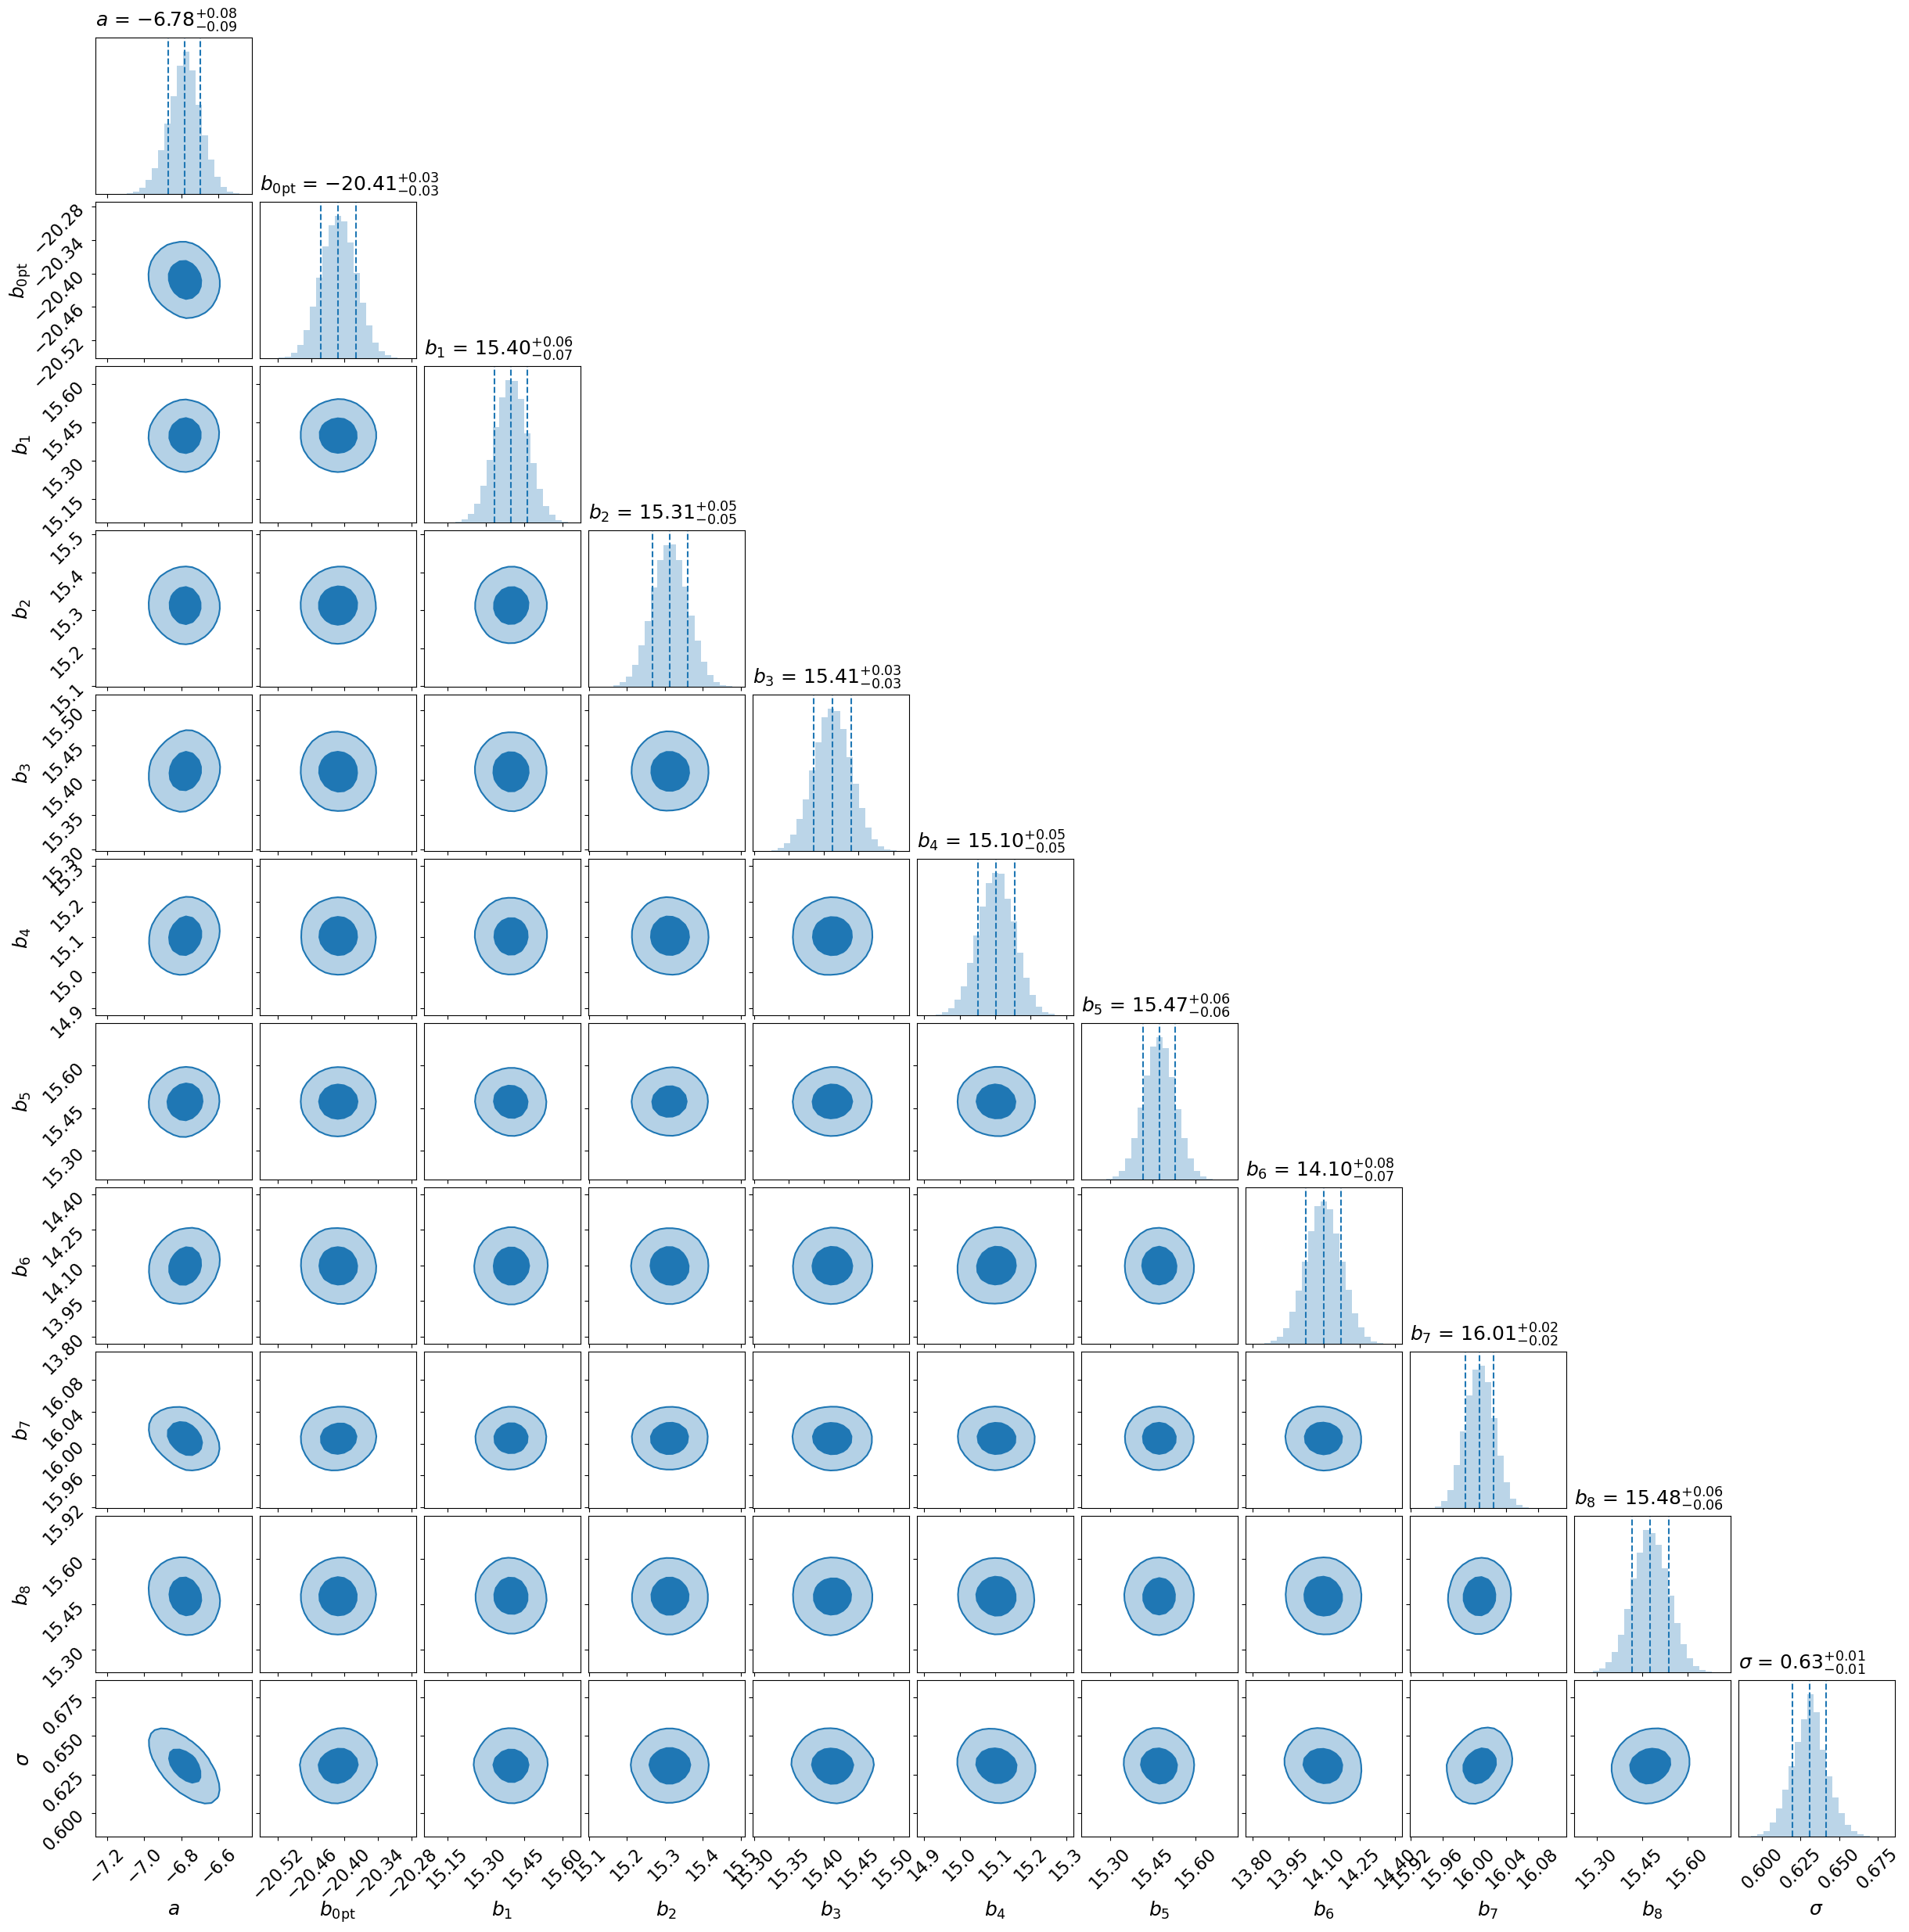

In [52]:
labels  = ['$a$']
labels += [r'$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10})

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_corner0_20241220.png', 
#             dpi=150, 
#             facecolor='none')

### Plot the HyperFit Results

In [53]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

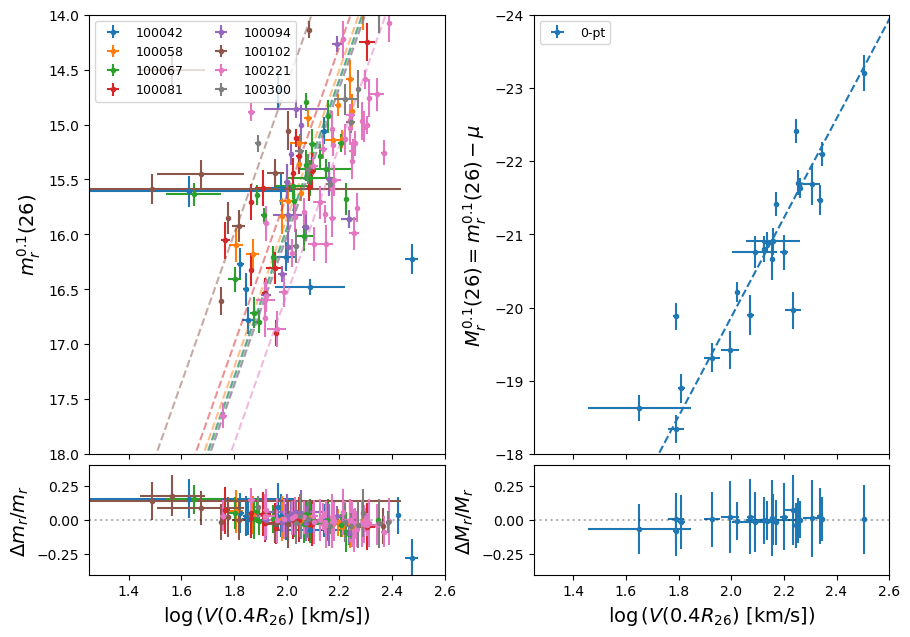

In [54]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 14]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_cluster_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_fit0_20241220.png', 
            # dpi=150, 
            # facecolor='none')

Text(0.02, 0.5, '$m_r^{0.1} (26)$')

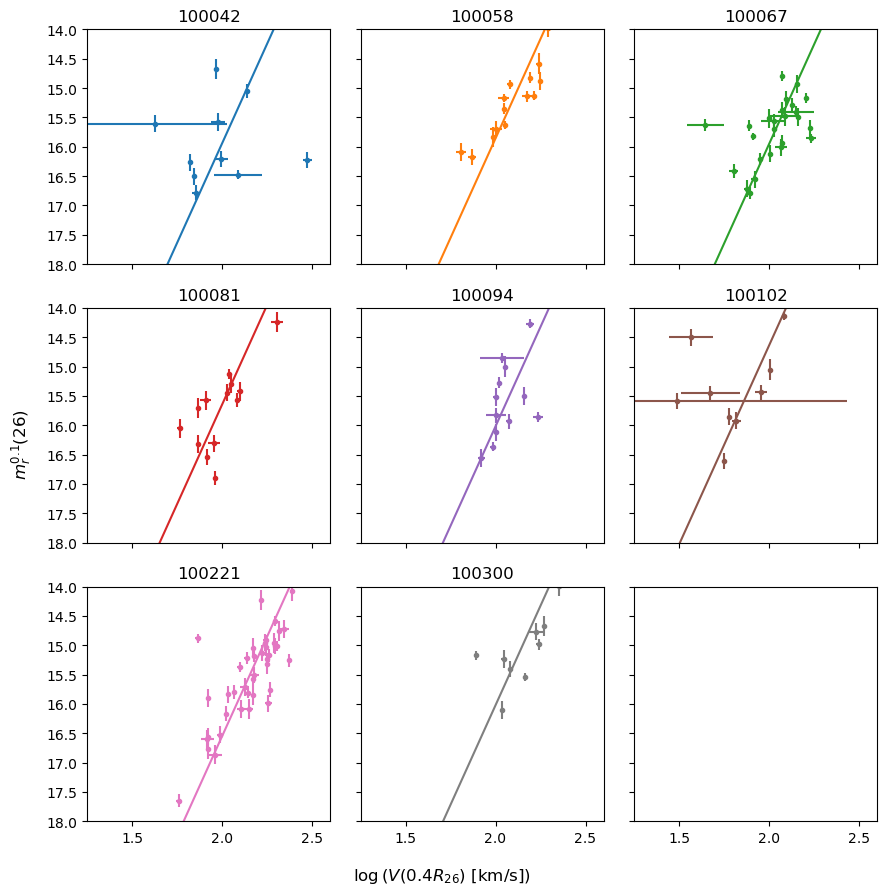

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(9,9), tight_layout=True)

color = iter(plt.get_cmap('tab10').colors)
for i in range(m):
    c = next(color)
    
    row = int(i/3)
    col = i%3
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 14], title=f'{_cluster_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$')

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [56]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

37.77657457960363 km/s


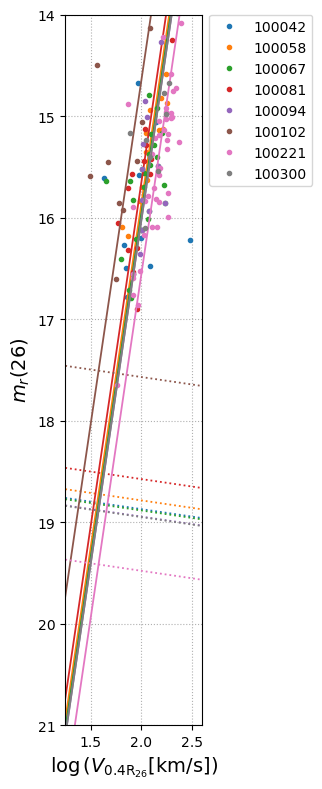

In [57]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_cluster_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_clusters[_cluster_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 14)

plt.gca().set_aspect('equal')

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm cluster \perp}
\end{equation}

In [58]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this cluster's nest ID
    nestid = _cluster_ids[i]
    
    # Find all galaxies in this cluster
    cluster_gal_idx = caltab['CLUSTER_ID'] == nestid
    
    # Find which of these cluster galaxies are dwarfs
    cluster_dwarfs = (caltab['R_MAG_SB26_CORR'][cluster_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][cluster_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][cluster_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[cluster_gal_idx] = cluster_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
